In [2]:
import jax
from jax import config

config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jr
from jax import grad, jit, vmap
from jax.scipy.ndimage import map_coordinates
import jax.lax as lax
import optax
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dlT
import math
import numpy as np
import equinox as eqx
import zodiax as zdx
import optax

from global_polynomial_functions import (
    create_image_coords,
    get_polynomial_powers,
    sample_image_at_distorted_coords,
    get_dither_offsets_random,
    fit_polynomial_adam,
    compute_parameter_loss,
)

# This was made using Connor's help - I think it's mostly a direct copy of code he already has in his repo.
phase_mask = np.load("/Users/angusrutherford/Desktop/dLuxToliman/new_diffractive_pupil.npy")

mask = dl.Optic(phase=phase_mask)

wavefront_npix = 2000 # 2000 # Wavefront number of pixels
aperture_diam = 0.125 # Diameter of aperture (m)
oversample = 1
coords = dlu.pixel_coords(wavefront_npix * oversample, aperture_diam)
secondary_diam = 0.032 # Diameter of secondary mirror (m)
spider_width = 0.002 # Spider width (m)
#psf_npixels = 256 #3600 # Number of pixels across one axis on detector
psf_npixels = 100
pixel_scale = 0.375 # Converting angle between binary source to angle on detector
primary = dlu.circle(coords, aperture_diam/2)
secondary = dlu.circle(coords, secondary_diam/2, invert=True)
angles = [0, 120, 240]
spiders = dlu.spider(coords, spider_width, angles)

aperture = dlu.combine([primary, secondary, spiders], oversample)

# Define the optical layers
layers = [("aperture", dl.layers.Optic(aperture, normalise=True)), ("phase_mask", mask)]

# Construct the optics object
# optics = dl.AngularOpticalSystem(wavefront_npix, aperture_diam, layers, psf_npixels, pixel_scale, oversample)
optics = dlT.TolimanOpticalSystem(
    wavefront_npix,
    psf_npixels,
    oversample,
    pixel_scale,
    mask=mask,
    radial_orders=[6]
    )

In [26]:
N = 100
pixel_scale = 0.375
coords = create_image_coords(N, pixel_scale)
order = 7
powers = get_polynomial_powers(order)
n_terms = len(powers)
det_pixsize = dlu.arcsec2rad(pixel_scale)
true_params = 1e-4 * jax.random.normal(jax.random.PRNGKey(0), shape=(2*n_terms,))
key = jax.random.PRNGKey(13)
N_list = [0, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]
#N_list = [0]  # in place of your old ks
#N_list = [1, 10000]  # in place of your old ks

best_params_list             = []
final_loss_list              = []
loss_history_list            = []
parameter_squared_loss_list  = []
parameter_absolute_loss_list = []
mismatch_mean_list           = []
mismatch_std_list            = []
final_params_list            = []
mse_history_list             = []

for N_images in tqdm(N_list, desc="Outer Loop (N_images)", position=0):
    dither_offsets = get_dither_offsets_random(1, det_pixsize, r_factor=jnp.sqrt(3), key=key)
    psfs = []
    for offset in dither_offsets:
        src = dlT.AlphaCen(
            n_wavels=3, separation=10.0, position_angle=90,
            x_position=offset[0], y_position=offset[1],
            log_flux=7.832, contrast=3.37,
            bandpass=(530, 640), weights=None
        )
        psfs.append(dlT.Toliman(optics, src).model())
    ideal_images = jnp.stack(psfs)

    distorted_clean = jnp.stack([
        sample_image_at_distorted_coords(psf, true_params, coords, powers)
        for psf in ideal_images
    ])
    
    read_sigma = 0 
    if N_images == 0:
        distorted_images = distorted_clean
        N_images = 1
        read_sigma = 0.0
    else:
        
        key, sub = jr.split(key)                                   # master split
        subkeys   = jr.split(sub, distorted_clean.shape[0])        # one key per PSF
        psf_sum = jnp.stack([jr.poisson(k, lam=img * N_images) +
        jr.normal(k, img.shape) * read_sigma * np.sqrt(N_images)
        for k, img in zip(subkeys, distorted_clean)])                                                   # shape (B, H, W)

        distorted_images = (psf_sum / N_images).astype(jnp.float32)
    # resid_init = distorted_clean[0] - distorted_images[0]
    # var = distorted_clean[0] / N_images + 0 / N_images + 1e-8
    # initial_loss = jnp.sum((resid_init ** 2) / var)
    #print(f"Initial loss: {initial_loss:.3e}")
    # 4) Fit, telling the function how many images we averaged
    params, final_loss, loss_history, mismatch_mean, mismatch_std, final_arr, params_list, MSE_history = fit_polynomial_adam(
            ideal_images,
            distorted_images,
            coords,
            powers,
            learning_rate=1e-5,
            num_steps=4001,
            avg_window=300,
            true_params=true_params,
            n_images=N_images,         # <— pass N_images
            read_noise_var=read_sigma**2,        # or set to your read_noise**2
            epsilon=1e-8
        )
    # 5) Store results exactly as before
    best_params_list.append(params)
    final_loss_list.append(final_loss)
    loss_history_list.append(loss_history)
    mismatch_mean_list.append(mismatch_mean)
    mismatch_std_list.append(mismatch_std)
    sq_loss, abs_loss = compute_parameter_loss(true_params, params)
    parameter_squared_loss_list.append(sq_loss)
    parameter_absolute_loss_list.append(abs_loss)
    final_params_list.append(final_arr)
    mse_history_list.append(MSE_history)


Outer Loop (N_images):   0%|          | 0/10 [00:00<?, ?it/s]

Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 1.998711e+03 | MSE = 1.148e-08


KeyboardInterrupt: 

In [94]:
import jax, jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ────────────────────────────────────────────────────────────────
# 0) constants that were already defined earlier in your notebook
# ────────────────────────────────────────────────────────────────
N              = 100
pixel_scale    = 0.375
coords         = create_image_coords(N, pixel_scale)
order          = 7
powers         = get_polynomial_powers(order)
n_terms        = len(powers)
det_pixsize    = dlu.arcsec2rad(pixel_scale)
true_params    = 1e-4 * jr.normal(jr.PRNGKey(0), shape=(2 * n_terms,))

# ────────────────────────────────────────────────────────────────
# 1) master dither geometry (25 offsets)  →  ideal & distorted PSFs
# ────────────────────────────────────────────────────────────────
key_geom         = jr.PRNGKey(11)                            # fixed
master_offsets   = get_dither_offsets_random(
                       25, det_pixsize, r_factor=jnp.sqrt(3), key=key_geom)

# build noiseless PSFs once
psfs = []
for off in master_offsets:
    src = dlT.AlphaCen(
        n_wavels=3, separation=10.0, position_angle=90,
        x_position=off[0], y_position=off[1],
        log_flux=7.832, contrast=3.37, bandpass=(530, 640))
    psfs.append(dlT.Toliman(optics, src).model())
ideal_master = jnp.stack(psfs)                               # (25,H,W)

# apply the true global-polynomial warp once
distorted_clean_master = jnp.stack([
    sample_image_at_distorted_coords(psf, true_params, coords, powers)
    for psf in ideal_master
])                                                           # (25,H,W)

# ────────────────────────────────────────────────────────────────
# 2) pre-bake one noisy cube per exposure count
# ────────────────────────────────────────────────────────────────
N_list = [0, 1, 10, 100, 1_000, 10_000, 100_000]
#N_list = [10, 100]   # (fixed typo!)
key_noise_seed = jr.PRNGKey(22)                    # independent seed
read_sigma = 3.27                                  # set if you want read noise

noisy_cubes = {}                                   # N_images → (25,H,W)
for N_images in N_list:
    if N_images == 0:
        noisy_cubes[0] = distorted_clean_master
        continue

    key_N    = jr.fold_in(key_noise_seed, N_images)        # deterministic key
    subkeys  = jr.split(key_N, 25)                         # one per dither
    psf_sum  = jnp.stack([
        jr.poisson(k, lam=img * N_images) +
        jr.normal (k, img.shape) * read_sigma * jnp.sqrt(N_images)
        for k, img in zip(subkeys, distorted_clean_master)
    ])
    noisy_cubes[N_images] = (psf_sum / N_images).astype(jnp.float32)

# ────────────────────────────────────────────────────────────────
# 3) allocate 2-D result grids
# ────────────────────────────────────────────────────────────────
dither_list = [1, 5, 9, 13, 17, 21, 25]
#dither_list = [5, 9]
n_dithers, n_Ns = len(dither_list), len(N_list)

def make_grid(init_val):
    return [[init_val for _ in range(n_Ns)] for _ in range(n_dithers)]

best_params_grid   = make_grid(None)
final_loss_grid    = np.empty((n_dithers, n_Ns))
loss_history_grid  = make_grid(None)
param_sq_loss_grid = np.empty((n_dithers, n_Ns))
param_abs_loss_grid= np.empty((n_dithers, n_Ns))
final_params_grid  = make_grid(None)
mse_history_grid   = make_grid(None)
mismatch_mean_grid = np.empty((n_dithers, n_Ns))
mismatch_std_grid  = np.empty((n_dithers, n_Ns))
plots = []
# ────────────────────────────────────────────────────────────────
# 4) sweep k_dithers × N_images
# ────────────────────────────────────────────────────────────────
for i_d, k_dithers in enumerate(dither_list):

    ideal_k      = ideal_master          [:k_dithers]      # nested offsets
    distorted_k0 = distorted_clean_master[:k_dithers]

    for j_N, N_images in enumerate(N_list):
        print(f"i_d={i_d}, j_N={j_N}, k={k_dithers}, N={N_images}")

        distorted_images = noisy_cubes[N_images][:k_dithers]
        N_eff            = max(N_images, 1)                # avoid N=0 inside loss

        (params_avg, final_loss, loss_hist,
         mismatch_mean, mismatch_std,
         final_arr, params_list, mse_hist) = fit_polynomial_adam(
            ideal_k, distorted_images,
            coords, powers,
            learning_rate = 1e-5,
            num_steps     = 4001,
            avg_window    = 300,
            true_params   = true_params,
            n_images      = N_eff,
            read_noise_var= read_sigma**2,
            epsilon       = 1e-8,
        )

        # store
        best_params_grid   [i_d][j_N] = params_avg
        final_loss_grid    [i_d, j_N] = final_loss
        loss_history_grid  [i_d][j_N] = loss_hist
        final_params_grid  [i_d][j_N] = final_arr
        mse_history_grid   [i_d][j_N] = mse_hist
        mismatch_mean_grid [i_d, j_N] = mismatch_mean
        mismatch_std_grid  [i_d, j_N] = mismatch_std

        sq_l, abs_l = compute_parameter_loss(true_params, params_avg)
        param_sq_loss_grid [i_d, j_N] = sq_l
        param_abs_loss_grid[i_d, j_N] = abs_l

i_d=0, j_N=0, k=1, N=0


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 1.986683e+03 | MSE = 1.148e-08
Step  500 | Loss = 1.856172e-01 | MSE = 7.262e-10
Step 1000 | Loss = 1.294342e-01 | MSE = 9.730e-11
Step 1500 | Loss = 8.662711e-02 | MSE = 1.193e-11
Step 2000 | Loss = 4.522753e-02 | MSE = 1.388e-12
Step 2500 | Loss = 1.511285e-02 | MSE = 2.458e-13
Step 3000 | Loss = 2.454790e-03 | MSE = 4.355e-14
Step 3500 | Loss = 1.500750e-03 | MSE = 1.178e-14
Step 4000 | Loss = 1.497642e-03 | MSE = 4.947e-15
i_d=0, j_N=1, k=1, N=1


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 1.197985e+04 | MSE = 1.148e-08
Step  500 | Loss = 9.925953e+03 | MSE = 1.919e-07
Step 1000 | Loss = 9.920289e+03 | MSE = 4.485e-07
Step 1500 | Loss = 9.918519e+03 | MSE = 6.477e-07
Step 2000 | Loss = 9.917611e+03 | MSE = 7.687e-07
Step 2500 | Loss = 9.917156e+03 | MSE = 8.566e-07
Step 3000 | Loss = 9.916886e+03 | MSE = 9.020e-07
Step 3500 | Loss = 9.916819e+03 | MSE = 9.266e-07
Step 4000 | Loss = 9.916769e+03 | MSE = 9.439e-07
i_d=0, j_N=2, k=1, N=10


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 2.751158e+04 | MSE = 1.148e-08
Step  500 | Loss = 8.499823e+03 | MSE = 3.060e-08
Step 1000 | Loss = 8.481511e+03 | MSE = 4.982e-08
Step 1500 | Loss = 8.481223e+03 | MSE = 6.347e-08
Step 2000 | Loss = 8.482814e+03 | MSE = 6.827e-08
Step 2500 | Loss = 8.480137e+03 | MSE = 7.076e-08
Step 3000 | Loss = 8.479263e+03 | MSE = 7.225e-08
Step 3500 | Loss = 8.479255e+03 | MSE = 7.336e-08
Step 4000 | Loss = 8.479262e+03 | MSE = 7.366e-08
i_d=0, j_N=3, k=1, N=100


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 1.512568e+05 | MSE = 1.148e-08
Step  500 | Loss = 4.835810e+03 | MSE = 6.112e-09
Step 1000 | Loss = 4.832842e+03 | MSE = 1.241e-08
Step 1500 | Loss = 4.827409e+03 | MSE = 1.484e-08
Step 2000 | Loss = 4.826070e+03 | MSE = 1.567e-08
Step 2500 | Loss = 4.824449e+03 | MSE = 1.582e-08
Step 3000 | Loss = 4.823124e+03 | MSE = 1.585e-08
Step 3500 | Loss = 4.822868e+03 | MSE = 1.592e-08
Step 4000 | Loss = 4.822888e+03 | MSE = 1.598e-08
i_d=0, j_N=4, k=1, N=1000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 6.890930e+05 | MSE = 1.148e-08
Step  500 | Loss = 1.870249e+03 | MSE = 3.068e-09
Step 1000 | Loss = 1.858660e+03 | MSE = 3.333e-09
Step 1500 | Loss = 1.840322e+03 | MSE = 3.784e-09
Step 2000 | Loss = 1.827696e+03 | MSE = 3.991e-09
Step 2500 | Loss = 1.817815e+03 | MSE = 4.087e-09
Step 3000 | Loss = 1.814493e+03 | MSE = 4.114e-09
Step 3500 | Loss = 1.813632e+03 | MSE = 4.072e-09
Step 4000 | Loss = 1.813629e+03 | MSE = 4.070e-09
i_d=0, j_N=5, k=1, N=10000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 1.511551e+06 | MSE = 1.148e-08
Step  500 | Loss = 6.214517e+02 | MSE = 1.881e-09
Step 1000 | Loss = 6.300035e+02 | MSE = 7.882e-10
Step 1500 | Loss = 5.882993e+02 | MSE = 5.890e-10
Step 2000 | Loss = 5.359964e+02 | MSE = 5.587e-10
Step 2500 | Loss = 5.071085e+02 | MSE = 5.526e-10
Step 3000 | Loss = 4.933181e+02 | MSE = 5.507e-10
Step 3500 | Loss = 4.905361e+02 | MSE = 5.514e-10
Step 4000 | Loss = 4.905209e+02 | MSE = 5.520e-10
i_d=0, j_N=6, k=1, N=100000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 1.829996e+06 | MSE = 1.148e-08
Step  500 | Loss = 1.765698e+02 | MSE = 1.999e-09
Step 1000 | Loss = 1.361700e+02 | MSE = 5.488e-10
Step 1500 | Loss = 1.055880e+02 | MSE = 1.980e-10
Step 2000 | Loss = 8.458955e+01 | MSE = 1.151e-10
Step 2500 | Loss = 7.119589e+01 | MSE = 9.265e-11
Step 3000 | Loss = 6.507885e+01 | MSE = 8.503e-11
Step 3500 | Loss = 6.319609e+01 | MSE = 8.171e-11
Step 4000 | Loss = 6.320322e+01 | MSE = 8.024e-11
i_d=1, j_N=0, k=5, N=0


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 9.933402e+03 | MSE = 1.148e-08
Step  500 | Loss = 8.111301e-01 | MSE = 5.226e-10
Step 1000 | Loss = 7.753255e-01 | MSE = 4.561e-11
Step 1500 | Loss = 5.799738e-01 | MSE = 4.394e-12
Step 2000 | Loss = 2.735958e-01 | MSE = 6.444e-13
Step 2500 | Loss = 6.288354e-02 | MSE = 1.437e-13
Step 3000 | Loss = 9.562844e-03 | MSE = 2.583e-14
Step 3500 | Loss = 5.960997e-03 | MSE = 7.315e-15
Step 4000 | Loss = 5.955241e-03 | MSE = 3.447e-15
i_d=1, j_N=1, k=5, N=1


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 6.017572e+04 | MSE = 1.148e-08
Step  500 | Loss = 4.966988e+04 | MSE = 7.706e-08
Step 1000 | Loss = 4.966405e+04 | MSE = 1.679e-07
Step 1500 | Loss = 4.967115e+04 | MSE = 2.183e-07
Step 2000 | Loss = 4.966235e+04 | MSE = 2.323e-07
Step 2500 | Loss = 4.966253e+04 | MSE = 2.414e-07
Step 3000 | Loss = 4.966210e+04 | MSE = 2.453e-07
Step 3500 | Loss = 4.966207e+04 | MSE = 2.467e-07
Step 4000 | Loss = 4.966207e+04 | MSE = 2.474e-07
i_d=1, j_N=2, k=5, N=10


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 1.392535e+05 | MSE = 1.148e-08
Step  500 | Loss = 4.350972e+04 | MSE = 7.635e-09
Step 1000 | Loss = 4.349200e+04 | MSE = 1.428e-08
Step 1500 | Loss = 4.348825e+04 | MSE = 1.875e-08
Step 2000 | Loss = 4.348627e+04 | MSE = 2.183e-08
Step 2500 | Loss = 4.348523e+04 | MSE = 2.291e-08
Step 3000 | Loss = 4.348462e+04 | MSE = 2.327e-08
Step 3500 | Loss = 4.348441e+04 | MSE = 2.338e-08
Step 4000 | Loss = 4.348464e+04 | MSE = 2.344e-08
i_d=1, j_N=3, k=5, N=100


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 7.577038e+05 | MSE = 1.148e-08
Step  500 | Loss = 2.426042e+04 | MSE = 2.111e-09
Step 1000 | Loss = 2.427654e+04 | MSE = 2.532e-09
Step 1500 | Loss = 2.425832e+04 | MSE = 2.844e-09
Step 2000 | Loss = 2.424472e+04 | MSE = 2.993e-09
Step 2500 | Loss = 2.423002e+04 | MSE = 3.079e-09
Step 3000 | Loss = 2.422690e+04 | MSE = 3.138e-09
Step 3500 | Loss = 2.422577e+04 | MSE = 3.144e-09
Step 4000 | Loss = 2.422571e+04 | MSE = 3.150e-09
i_d=1, j_N=4, k=5, N=1000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 3.448839e+06 | MSE = 1.148e-08
Step  500 | Loss = 9.661493e+03 | MSE = 1.739e-09
Step 1000 | Loss = 9.564956e+03 | MSE = 9.446e-10
Step 1500 | Loss = 9.476621e+03 | MSE = 9.893e-10
Step 2000 | Loss = 9.378044e+03 | MSE = 1.072e-09
Step 2500 | Loss = 9.343125e+03 | MSE = 1.116e-09
Step 3000 | Loss = 9.327089e+03 | MSE = 1.126e-09
Step 3500 | Loss = 9.324103e+03 | MSE = 1.129e-09
Step 4000 | Loss = 9.324089e+03 | MSE = 1.129e-09
i_d=1, j_N=5, k=5, N=10000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 7.563461e+06 | MSE = 1.148e-08
Step  500 | Loss = 2.877984e+03 | MSE = 2.189e-09
Step 1000 | Loss = 4.124165e+03 | MSE = 8.056e-10
Step 1500 | Loss = 2.508660e+03 | MSE = 3.164e-10
Step 2000 | Loss = 2.399606e+03 | MSE = 1.732e-10
Step 2500 | Loss = 2.363621e+03 | MSE = 1.436e-10
Step 3000 | Loss = 2.328150e+03 | MSE = 1.303e-10
Step 3500 | Loss = 2.322210e+03 | MSE = 1.231e-10
Step 4000 | Loss = 2.322380e+03 | MSE = 1.185e-10
i_d=1, j_N=6, k=5, N=100000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 9.149691e+06 | MSE = 1.148e-08
Step  500 | Loss = 8.351024e+02 | MSE = 2.086e-09
Step 1000 | Loss = 6.278225e+02 | MSE = 5.949e-10
Step 1500 | Loss = 5.731774e+02 | MSE = 1.779e-10
Step 2000 | Loss = 4.097855e+02 | MSE = 6.948e-11
Step 2500 | Loss = 3.293441e+02 | MSE = 3.556e-11
Step 3000 | Loss = 2.986298e+02 | MSE = 2.410e-11
Step 3500 | Loss = 2.949140e+02 | MSE = 2.005e-11
Step 4000 | Loss = 2.949201e+02 | MSE = 1.858e-11
i_d=2, j_N=0, k=9, N=0


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 1.788016e+04 | MSE = 1.148e-08
Step  500 | Loss = 4.274877e+00 | MSE = 1.103e-09
Step 1000 | Loss = 1.332121e+00 | MSE = 1.287e-10
Step 1500 | Loss = 9.744052e-01 | MSE = 1.253e-11
Step 2000 | Loss = 5.391808e-01 | MSE = 1.456e-12
Step 2500 | Loss = 1.413470e-01 | MSE = 2.637e-13
Step 3000 | Loss = 2.298540e-02 | MSE = 5.015e-14
Step 3500 | Loss = 1.411361e-02 | MSE = 1.323e-14
Step 4000 | Loss = 1.408392e-02 | MSE = 5.378e-15
i_d=2, j_N=1, k=9, N=1


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 1.082860e+05 | MSE = 1.148e-08
Step  500 | Loss = 8.979750e+04 | MSE = 3.260e-08
Step 1000 | Loss = 8.978962e+04 | MSE = 8.184e-08
Step 1500 | Loss = 8.978782e+04 | MSE = 1.131e-07
Step 2000 | Loss = 8.979821e+04 | MSE = 1.315e-07
Step 2500 | Loss = 8.978675e+04 | MSE = 1.358e-07
Step 3000 | Loss = 8.978656e+04 | MSE = 1.388e-07
Step 3500 | Loss = 8.978654e+04 | MSE = 1.401e-07
Step 4000 | Loss = 8.978645e+04 | MSE = 1.413e-07
i_d=2, j_N=2, k=9, N=10


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 2.500536e+05 | MSE = 1.148e-08
Step  500 | Loss = 7.853627e+04 | MSE = 7.872e-09
Step 1000 | Loss = 7.852030e+04 | MSE = 1.849e-08
Step 1500 | Loss = 7.851622e+04 | MSE = 2.612e-08
Step 2000 | Loss = 7.851331e+04 | MSE = 3.011e-08
Step 2500 | Loss = 7.851071e+04 | MSE = 3.191e-08
Step 3000 | Loss = 7.850979e+04 | MSE = 3.287e-08
Step 3500 | Loss = 7.850960e+04 | MSE = 3.319e-08
Step 4000 | Loss = 7.850958e+04 | MSE = 3.328e-08
i_d=2, j_N=3, k=9, N=100


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 1.362995e+06 | MSE = 1.148e-08
Step  500 | Loss = 4.403703e+04 | MSE = 1.352e-09
Step 1000 | Loss = 4.406691e+04 | MSE = 1.441e-09
Step 1500 | Loss = 4.403753e+04 | MSE = 1.687e-09
Step 2000 | Loss = 4.401376e+04 | MSE = 1.823e-09
Step 2500 | Loss = 4.399883e+04 | MSE = 1.855e-09
Step 3000 | Loss = 4.399215e+04 | MSE = 1.854e-09
Step 3500 | Loss = 4.399027e+04 | MSE = 1.856e-09
Step 4000 | Loss = 4.399023e+04 | MSE = 1.857e-09
i_d=2, j_N=4, k=9, N=1000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 6.209855e+06 | MSE = 1.148e-08
Step  500 | Loss = 1.751566e+04 | MSE = 1.504e-09
Step 1000 | Loss = 1.749045e+04 | MSE = 4.689e-10
Step 1500 | Loss = 1.732662e+04 | MSE = 3.153e-10
Step 2000 | Loss = 1.709347e+04 | MSE = 2.968e-10
Step 2500 | Loss = 1.695055e+04 | MSE = 2.933e-10
Step 3000 | Loss = 1.691240e+04 | MSE = 2.971e-10
Step 3500 | Loss = 1.690813e+04 | MSE = 2.956e-10
Step 4000 | Loss = 1.690846e+04 | MSE = 2.943e-10
i_d=2, j_N=5, k=9, N=10000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 1.361154e+07 | MSE = 1.148e-08
Step  500 | Loss = 5.615673e+03 | MSE = 1.918e-09
Step 1000 | Loss = 5.746401e+03 | MSE = 6.137e-10
Step 1500 | Loss = 5.267332e+03 | MSE = 2.770e-10
Step 2000 | Loss = 4.756244e+03 | MSE = 1.767e-10
Step 2500 | Loss = 4.418242e+03 | MSE = 1.422e-10
Step 3000 | Loss = 4.282343e+03 | MSE = 1.279e-10
Step 3500 | Loss = 4.254370e+03 | MSE = 1.212e-10
Step 4000 | Loss = 4.254253e+03 | MSE = 1.181e-10
i_d=2, j_N=6, k=9, N=100000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 1.646926e+07 | MSE = 1.148e-08
Step  500 | Loss = 1.346797e+03 | MSE = 1.942e-09
Step 1000 | Loss = 3.681166e+03 | MSE = 7.860e-10
Step 1500 | Loss = 4.638814e+03 | MSE = 3.208e-10
Step 2000 | Loss = 3.426157e+03 | MSE = 1.946e-10
Step 2500 | Loss = 7.674612e+02 | MSE = 1.197e-10
Step 3000 | Loss = 5.419720e+02 | MSE = 8.257e-11
Step 3500 | Loss = 5.314490e+02 | MSE = 5.304e-11
Step 4000 | Loss = 5.305800e+02 | MSE = 3.272e-11
i_d=3, j_N=0, k=13, N=0


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 2.582688e+04 | MSE = 1.148e-08
Step  500 | Loss = 1.837226e+00 | MSE = 6.719e-10
Step 1000 | Loss = 4.662398e+00 | MSE = 1.424e-10
Step 1500 | Loss = 1.421779e+01 | MSE = 5.158e-11
Step 2000 | Loss = 7.757188e-01 | MSE = 1.417e-11
Step 2500 | Loss = 3.336516e-01 | MSE = 3.691e-12
Step 3000 | Loss = 3.160611e-02 | MSE = 5.085e-13
Step 3500 | Loss = 1.141289e-01 | MSE = 1.218e-13
Step 4000 | Loss = 2.309686e-02 | MSE = 2.137e-14
i_d=3, j_N=1, k=13, N=1


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 1.558166e+05 | MSE = 1.148e-08
Step  500 | Loss = 1.293990e+05 | MSE = 2.558e-08
Step 1000 | Loss = 1.293898e+05 | MSE = 6.605e-08
Step 1500 | Loss = 1.293880e+05 | MSE = 8.492e-08
Step 2000 | Loss = 1.293873e+05 | MSE = 9.187e-08
Step 2500 | Loss = 1.293867e+05 | MSE = 9.426e-08
Step 3000 | Loss = 1.293865e+05 | MSE = 9.515e-08
Step 3500 | Loss = 1.293865e+05 | MSE = 9.565e-08
Step 4000 | Loss = 1.293865e+05 | MSE = 9.599e-08
i_d=3, j_N=2, k=13, N=10


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 3.602416e+05 | MSE = 1.148e-08
Step  500 | Loss = 1.131436e+05 | MSE = 5.854e-09
Step 1000 | Loss = 1.131340e+05 | MSE = 1.303e-08
Step 1500 | Loss = 1.131294e+05 | MSE = 1.699e-08
Step 2000 | Loss = 1.131253e+05 | MSE = 1.810e-08
Step 2500 | Loss = 1.131220e+05 | MSE = 1.841e-08
Step 3000 | Loss = 1.131319e+05 | MSE = 1.866e-08
Step 3500 | Loss = 1.131206e+05 | MSE = 1.866e-08
Step 4000 | Loss = 1.131213e+05 | MSE = 1.866e-08
i_d=3, j_N=3, k=13, N=100


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 1.970272e+06 | MSE = 1.148e-08
Step  500 | Loss = 6.399426e+04 | MSE = 1.407e-09
Step 1000 | Loss = 6.381591e+04 | MSE = 8.050e-10
Step 1500 | Loss = 6.380259e+04 | MSE = 7.798e-10
Step 2000 | Loss = 6.378255e+04 | MSE = 8.247e-10
Step 2500 | Loss = 6.375967e+04 | MSE = 8.521e-10
Step 3000 | Loss = 6.374887e+04 | MSE = 8.582e-10
Step 3500 | Loss = 6.374695e+04 | MSE = 8.617e-10
Step 4000 | Loss = 6.374689e+04 | MSE = 8.624e-10
i_d=3, j_N=4, k=13, N=1000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 8.967971e+06 | MSE = 1.148e-08
Step  500 | Loss = 2.539681e+04 | MSE = 1.485e-09
Step 1000 | Loss = 2.536873e+04 | MSE = 4.282e-10
Step 1500 | Loss = 2.512798e+04 | MSE = 2.715e-10
Step 2000 | Loss = 2.486093e+04 | MSE = 2.491e-10
Step 2500 | Loss = 2.467805e+04 | MSE = 2.444e-10
Step 3000 | Loss = 2.463213e+04 | MSE = 2.432e-10
Step 3500 | Loss = 2.462456e+04 | MSE = 2.409e-10
Step 4000 | Loss = 2.462455e+04 | MSE = 2.393e-10
i_d=3, j_N=5, k=13, N=10000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 1.966014e+07 | MSE = 1.148e-08
Step  500 | Loss = 7.935685e+03 | MSE = 2.009e-09
Step 1000 | Loss = 8.106851e+03 | MSE = 5.620e-10
Step 1500 | Loss = 7.510245e+03 | MSE = 1.947e-10
Step 2000 | Loss = 6.765541e+03 | MSE = 9.857e-11
Step 2500 | Loss = 6.274996e+03 | MSE = 7.005e-11
Step 3000 | Loss = 6.054911e+03 | MSE = 6.144e-11
Step 3500 | Loss = 6.029178e+03 | MSE = 5.917e-11
Step 4000 | Loss = 6.028984e+03 | MSE = 5.894e-11
i_d=3, j_N=6, k=13, N=100000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 2.378972e+07 | MSE = 1.148e-08
Step  500 | Loss = 4.444092e+03 | MSE = 2.288e-09
Step 1000 | Loss = 5.216110e+03 | MSE = 7.531e-10
Step 1500 | Loss = 1.563304e+03 | MSE = 2.556e-10
Step 2000 | Loss = 1.096769e+03 | MSE = 9.745e-11
Step 2500 | Loss = 8.394955e+02 | MSE = 4.362e-11
Step 3000 | Loss = 7.838645e+02 | MSE = 2.338e-11
Step 3500 | Loss = 7.657314e+02 | MSE = 1.469e-11
Step 4000 | Loss = 7.664925e+02 | MSE = 1.050e-11
i_d=4, j_N=0, k=17, N=0


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 3.377360e+04 | MSE = 1.148e-08
Step  500 | Loss = 2.647396e+00 | MSE = 6.226e-10
Step 1000 | Loss = 2.226864e+00 | MSE = 7.877e-11
Step 1500 | Loss = 1.594840e+00 | MSE = 8.448e-12
Step 2000 | Loss = 8.565331e-01 | MSE = 9.945e-13
Step 2500 | Loss = 2.679190e-01 | MSE = 1.996e-13
Step 3000 | Loss = 4.316707e-02 | MSE = 3.662e-14
Step 3500 | Loss = 2.613795e-02 | MSE = 1.019e-14
Step 4000 | Loss = 2.609419e-02 | MSE = 4.628e-15
i_d=4, j_N=1, k=17, N=1


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 2.040605e+05 | MSE = 1.148e-08
Step  500 | Loss = 1.693802e+05 | MSE = 2.611e-08
Step 1000 | Loss = 1.693564e+05 | MSE = 5.762e-08
Step 1500 | Loss = 1.693543e+05 | MSE = 7.620e-08
Step 2000 | Loss = 1.693538e+05 | MSE = 8.387e-08
Step 2500 | Loss = 1.693546e+05 | MSE = 8.634e-08
Step 3000 | Loss = 1.693529e+05 | MSE = 8.672e-08
Step 3500 | Loss = 1.693529e+05 | MSE = 8.707e-08
Step 4000 | Loss = 1.693529e+05 | MSE = 8.720e-08
i_d=4, j_N=2, k=17, N=10


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 4.712115e+05 | MSE = 1.148e-08
Step  500 | Loss = 1.478693e+05 | MSE = 4.261e-09
Step 1000 | Loss = 1.477651e+05 | MSE = 7.917e-09
Step 1500 | Loss = 1.477390e+05 | MSE = 1.080e-08
Step 2000 | Loss = 1.477326e+05 | MSE = 1.296e-08
Step 2500 | Loss = 1.477284e+05 | MSE = 1.374e-08
Step 3000 | Loss = 1.477264e+05 | MSE = 1.404e-08
Step 3500 | Loss = 1.477261e+05 | MSE = 1.415e-08
Step 4000 | Loss = 1.477300e+05 | MSE = 1.419e-08
i_d=4, j_N=3, k=17, N=100


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 2.577531e+06 | MSE = 1.148e-08
Step  500 | Loss = 8.332342e+04 | MSE = 1.459e-09
Step 1000 | Loss = 8.327952e+04 | MSE = 8.668e-10
Step 1500 | Loss = 8.325507e+04 | MSE = 8.501e-10
Step 2000 | Loss = 8.322460e+04 | MSE = 8.758e-10
Step 2500 | Loss = 8.319954e+04 | MSE = 8.956e-10
Step 3000 | Loss = 8.318871e+04 | MSE = 8.939e-10
Step 3500 | Loss = 8.318617e+04 | MSE = 8.889e-10
Step 4000 | Loss = 8.318627e+04 | MSE = 8.885e-10
i_d=4, j_N=4, k=17, N=1000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 1.172645e+07 | MSE = 1.148e-08
Step  500 | Loss = 3.278705e+04 | MSE = 1.519e-09
Step 1000 | Loss = 3.261318e+04 | MSE = 4.103e-10
Step 1500 | Loss = 3.245942e+04 | MSE = 2.420e-10
Step 2000 | Loss = 3.232132e+04 | MSE = 2.158e-10
Step 2500 | Loss = 3.220956e+04 | MSE = 2.082e-10
Step 3000 | Loss = 3.216691e+04 | MSE = 2.058e-10
Step 3500 | Loss = 3.214525e+04 | MSE = 2.036e-10
Step 4000 | Loss = 3.214530e+04 | MSE = 2.021e-10
i_d=4, j_N=5, k=17, N=10000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 2.570800e+07 | MSE = 1.148e-08
Step  500 | Loss = 1.020308e+04 | MSE = 1.813e-09
Step 1000 | Loss = 1.044712e+04 | MSE = 4.589e-10
Step 1500 | Loss = 9.722127e+03 | MSE = 1.291e-10
Step 2000 | Loss = 8.710284e+03 | MSE = 5.175e-11
Step 2500 | Loss = 8.080457e+03 | MSE = 3.237e-11
Step 3000 | Loss = 7.850701e+03 | MSE = 2.787e-11
Step 3500 | Loss = 7.787046e+03 | MSE = 2.750e-11
Step 4000 | Loss = 7.786809e+03 | MSE = 2.821e-11
i_d=4, j_N=6, k=17, N=100000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 3.110800e+07 | MSE = 1.148e-08
Step  500 | Loss = 2.763206e+03 | MSE = 2.005e-09
Step 1000 | Loss = 2.102946e+03 | MSE = 5.687e-10
Step 1500 | Loss = 1.705889e+03 | MSE = 1.720e-10
Step 2000 | Loss = 1.423986e+03 | MSE = 6.523e-11
Step 2500 | Loss = 1.134856e+03 | MSE = 2.972e-11
Step 3000 | Loss = 1.020208e+03 | MSE = 1.584e-11
Step 3500 | Loss = 9.993942e+02 | MSE = 9.606e-12
Step 4000 | Loss = 9.994034e+02 | MSE = 6.660e-12
i_d=5, j_N=0, k=21, N=0


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 4.172035e+04 | MSE = 1.148e-08
Step  500 | Loss = 3.170193e+00 | MSE = 6.501e-10
Step 1000 | Loss = 4.325117e+01 | MSE = 1.445e-10
Step 1500 | Loss = 2.215342e+00 | MSE = 3.038e-11
Step 2000 | Loss = 9.151880e-01 | MSE = 5.870e-12
Step 2500 | Loss = 2.055697e-01 | MSE = 9.314e-13
Step 3000 | Loss = 3.722521e-02 | MSE = 1.255e-13
Step 3500 | Loss = 1.638750e-02 | MSE = 2.091e-14
Step 4000 | Loss = 2.100790e-02 | MSE = 5.874e-15
i_d=5, j_N=1, k=21, N=1


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 2.517942e+05 | MSE = 1.148e-08
Step  500 | Loss = 2.094202e+05 | MSE = 2.225e-08
Step 1000 | Loss = 2.093997e+05 | MSE = 5.435e-08
Step 1500 | Loss = 2.093974e+05 | MSE = 7.288e-08
Step 2000 | Loss = 2.093963e+05 | MSE = 7.911e-08
Step 2500 | Loss = 2.093956e+05 | MSE = 8.126e-08
Step 3000 | Loss = 2.093960e+05 | MSE = 8.230e-08
Step 3500 | Loss = 2.093951e+05 | MSE = 8.251e-08
Step 4000 | Loss = 2.093953e+05 | MSE = 8.270e-08
i_d=5, j_N=2, k=21, N=10


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 5.796012e+05 | MSE = 1.148e-08
Step  500 | Loss = 1.823954e+05 | MSE = 3.734e-09
Step 1000 | Loss = 1.823947e+05 | MSE = 6.461e-09
Step 1500 | Loss = 1.823871e+05 | MSE = 7.662e-09
Step 2000 | Loss = 1.823793e+05 | MSE = 8.266e-09
Step 2500 | Loss = 1.823730e+05 | MSE = 8.300e-09
Step 3000 | Loss = 1.823694e+05 | MSE = 8.323e-09
Step 3500 | Loss = 1.823688e+05 | MSE = 8.311e-09
Step 4000 | Loss = 1.823697e+05 | MSE = 8.301e-09
i_d=5, j_N=3, k=21, N=100


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 3.184711e+06 | MSE = 1.148e-08
Step  500 | Loss = 1.037584e+05 | MSE = 1.438e-09
Step 1000 | Loss = 1.061800e+05 | MSE = 8.737e-10
Step 1500 | Loss = 1.030072e+05 | MSE = 7.880e-10
Step 2000 | Loss = 1.030009e+05 | MSE = 7.953e-10
Step 2500 | Loss = 1.029627e+05 | MSE = 8.124e-10
Step 3000 | Loss = 1.029473e+05 | MSE = 8.253e-10
Step 3500 | Loss = 1.029653e+05 | MSE = 8.302e-10
Step 4000 | Loss = 1.029463e+05 | MSE = 8.302e-10
i_d=5, j_N=4, k=21, N=1000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 1.448513e+07 | MSE = 1.148e-08
Step  500 | Loss = 4.091310e+04 | MSE = 1.478e-09
Step 1000 | Loss = 4.085951e+04 | MSE = 4.005e-10
Step 1500 | Loss = 4.050316e+04 | MSE = 2.194e-10
Step 2000 | Loss = 4.006171e+04 | MSE = 1.805e-10
Step 2500 | Loss = 3.979067e+04 | MSE = 1.665e-10
Step 3000 | Loss = 3.967987e+04 | MSE = 1.618e-10
Step 3500 | Loss = 3.966603e+04 | MSE = 1.597e-10
Step 4000 | Loss = 3.966600e+04 | MSE = 1.581e-10
i_d=5, j_N=5, k=21, N=10000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 3.175634e+07 | MSE = 1.148e-08
Step  500 | Loss = 1.230449e+04 | MSE = 1.809e-09
Step 1000 | Loss = 1.255453e+04 | MSE = 4.689e-10
Step 1500 | Loss = 1.177792e+04 | MSE = 1.352e-10
Step 2000 | Loss = 1.083031e+04 | MSE = 5.024e-11
Step 2500 | Loss = 1.011722e+04 | MSE = 2.629e-11
Step 3000 | Loss = 9.834988e+03 | MSE = 1.889e-11
Step 3500 | Loss = 9.787766e+03 | MSE = 1.705e-11
Step 4000 | Loss = 9.785979e+03 | MSE = 1.708e-11
i_d=5, j_N=6, k=21, N=100000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 3.842739e+07 | MSE = 1.148e-08
Step  500 | Loss = 3.435276e+03 | MSE = 2.004e-09
Step 1000 | Loss = 2.613372e+03 | MSE = 5.781e-10
Step 1500 | Loss = 2.131584e+03 | MSE = 1.752e-10
Step 2000 | Loss = 1.699820e+03 | MSE = 6.470e-11
Step 2500 | Loss = 1.395223e+03 | MSE = 2.903e-11
Step 3000 | Loss = 1.258965e+03 | MSE = 1.516e-11
Step 3500 | Loss = 1.234951e+03 | MSE = 8.925e-12
Step 4000 | Loss = 1.234979e+03 | MSE = 5.954e-12
i_d=6, j_N=0, k=25, N=0


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 4.966708e+04 | MSE = 1.148e-08
Step  500 | Loss = 1.221854e+01 | MSE = 6.569e-10
Step 1000 | Loss = 3.107008e+00 | MSE = 1.084e-10
Step 1500 | Loss = 1.991153e+00 | MSE = 1.515e-11
Step 2000 | Loss = 1.136580e+00 | MSE = 1.852e-12
Step 2500 | Loss = 4.796961e-01 | MSE = 2.914e-13
Step 3000 | Loss = 1.044436e-01 | MSE = 5.190e-14
Step 3500 | Loss = 3.914063e-02 | MSE = 1.285e-14
Step 4000 | Loss = 3.922907e-02 | MSE = 5.256e-15
i_d=6, j_N=1, k=25, N=1


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 2.996430e+05 | MSE = 1.148e-08
Step  500 | Loss = 2.495268e+05 | MSE = 1.899e-08
Step 1000 | Loss = 2.495139e+05 | MSE = 3.539e-08
Step 1500 | Loss = 2.495131e+05 | MSE = 4.746e-08
Step 2000 | Loss = 2.495106e+05 | MSE = 5.306e-08
Step 2500 | Loss = 2.495095e+05 | MSE = 5.636e-08
Step 3000 | Loss = 2.495091e+05 | MSE = 5.770e-08
Step 3500 | Loss = 2.495092e+05 | MSE = 5.786e-08
Step 4000 | Loss = 2.495091e+05 | MSE = 5.791e-08
i_d=6, j_N=2, k=25, N=10


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 6.900987e+05 | MSE = 1.148e-08
Step  500 | Loss = 2.175839e+05 | MSE = 2.529e-09
Step 1000 | Loss = 2.175721e+05 | MSE = 4.114e-09
Step 1500 | Loss = 2.175632e+05 | MSE = 5.176e-09
Step 2000 | Loss = 2.175569e+05 | MSE = 5.643e-09
Step 2500 | Loss = 2.175483e+05 | MSE = 5.744e-09
Step 3000 | Loss = 2.175455e+05 | MSE = 5.781e-09
Step 3500 | Loss = 2.175452e+05 | MSE = 5.835e-09
Step 4000 | Loss = 2.175452e+05 | MSE = 5.840e-09
i_d=6, j_N=3, k=25, N=100


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 3.790606e+06 | MSE = 1.148e-08
Step  500 | Loss = 1.230010e+05 | MSE = 1.177e-09
Step 1000 | Loss = 1.228552e+05 | MSE = 6.788e-10
Step 1500 | Loss = 1.227856e+05 | MSE = 6.046e-10
Step 2000 | Loss = 1.226878e+05 | MSE = 6.368e-10
Step 2500 | Loss = 1.226366e+05 | MSE = 6.651e-10
Step 3000 | Loss = 1.226123e+05 | MSE = 6.772e-10
Step 3500 | Loss = 1.226096e+05 | MSE = 6.794e-10
Step 4000 | Loss = 1.226097e+05 | MSE = 6.793e-10
i_d=6, j_N=4, k=25, N=1000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 1.724511e+07 | MSE = 1.148e-08
Step  500 | Loss = 4.889003e+04 | MSE = 1.462e-09
Step 1000 | Loss = 4.886460e+04 | MSE = 3.766e-10
Step 1500 | Loss = 4.837697e+04 | MSE = 1.993e-10
Step 2000 | Loss = 4.776229e+04 | MSE = 1.575e-10
Step 2500 | Loss = 4.737345e+04 | MSE = 1.415e-10
Step 3000 | Loss = 4.724077e+04 | MSE = 1.355e-10
Step 3500 | Loss = 4.720372e+04 | MSE = 1.328e-10
Step 4000 | Loss = 4.720369e+04 | MSE = 1.311e-10
i_d=6, j_N=5, k=25, N=10000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 3.780993e+07 | MSE = 1.148e-08
Step  500 | Loss = 2.132997e+04 | MSE = 2.003e-09
Step 1000 | Loss = 1.389542e+04 | MSE = 7.517e-10
Step 1500 | Loss = 1.354614e+04 | MSE = 2.900e-10
Step 2000 | Loss = 1.270298e+04 | MSE = 9.452e-11
Step 2500 | Loss = 1.199222e+04 | MSE = 3.883e-11
Step 3000 | Loss = 1.169186e+04 | MSE = 2.302e-11
Step 3500 | Loss = 1.163387e+04 | MSE = 1.887e-11
Step 4000 | Loss = 1.163338e+04 | MSE = 1.853e-11
i_d=6, j_N=6, k=25, N=100000


Fitting:   0%|          | 0/4001 [00:00<?, ?it/s]

Step    0 | Loss = 4.574581e+07 | MSE = 1.148e-08
Step  500 | Loss = 4.659546e+03 | MSE = 2.041e-09
Step 1000 | Loss = 4.981689e+03 | MSE = 5.979e-10
Step 1500 | Loss = 4.243320e+03 | MSE = 1.831e-10
Step 2000 | Loss = 2.849471e+03 | MSE = 6.432e-11
Step 2500 | Loss = 1.940783e+03 | MSE = 2.734e-11
Step 3000 | Loss = 1.572312e+03 | MSE = 1.329e-11
Step 3500 | Loss = 1.492412e+03 | MSE = 7.131e-12
Step 4000 | Loss = 1.491804e+03 | MSE = 4.256e-12


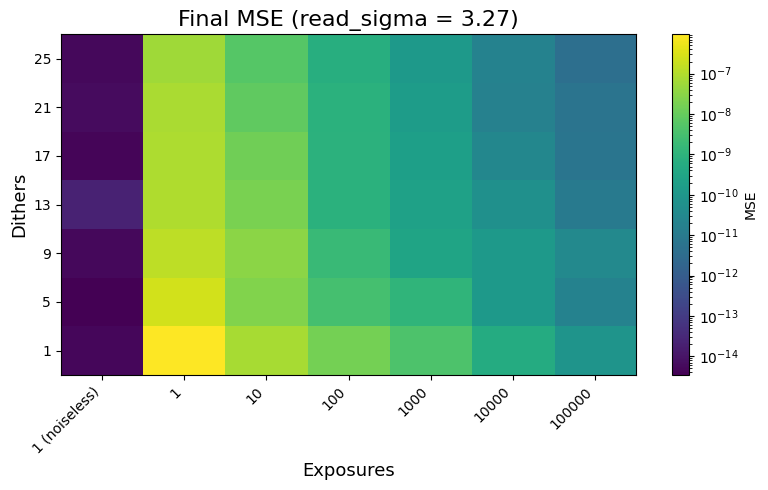

In [98]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# 1) build 2-D grid of final MSEs
param_mse_grid = np.empty((n_dithers, n_Ns))
for i in range(n_dithers):
    for j in range(n_Ns):
        param_mse_grid[i, j] = mse_history_grid[i][j][-1]

# 2) labels – overwrite the first one
xlabels = [f"1 (noiseless)"] + [str(n) for n in N_list[1:]]

# 3) plot
fig, ax = plt.subplots(figsize=(8, 5))

im = ax.imshow(param_mse_grid,
               origin='lower',
               aspect='auto',
               cmap='viridis',
               norm=mpl.colors.LogNorm())

ax.set_xticks(range(n_Ns))
ax.set_xticklabels(xlabels, rotation=45, ha='right')
ax.set_yticks(range(n_dithers))
ax.set_yticklabels([str(k) for k in dither_list])
ax.set_xlabel("Exposures", fontsize = 13)
ax.set_ylabel("Dithers", fontsize = 13)
ax.set_title("Final MSE (read_sigma = 3.27)", fontsize = 16)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("MSE")

plt.tight_layout()
plt.show()




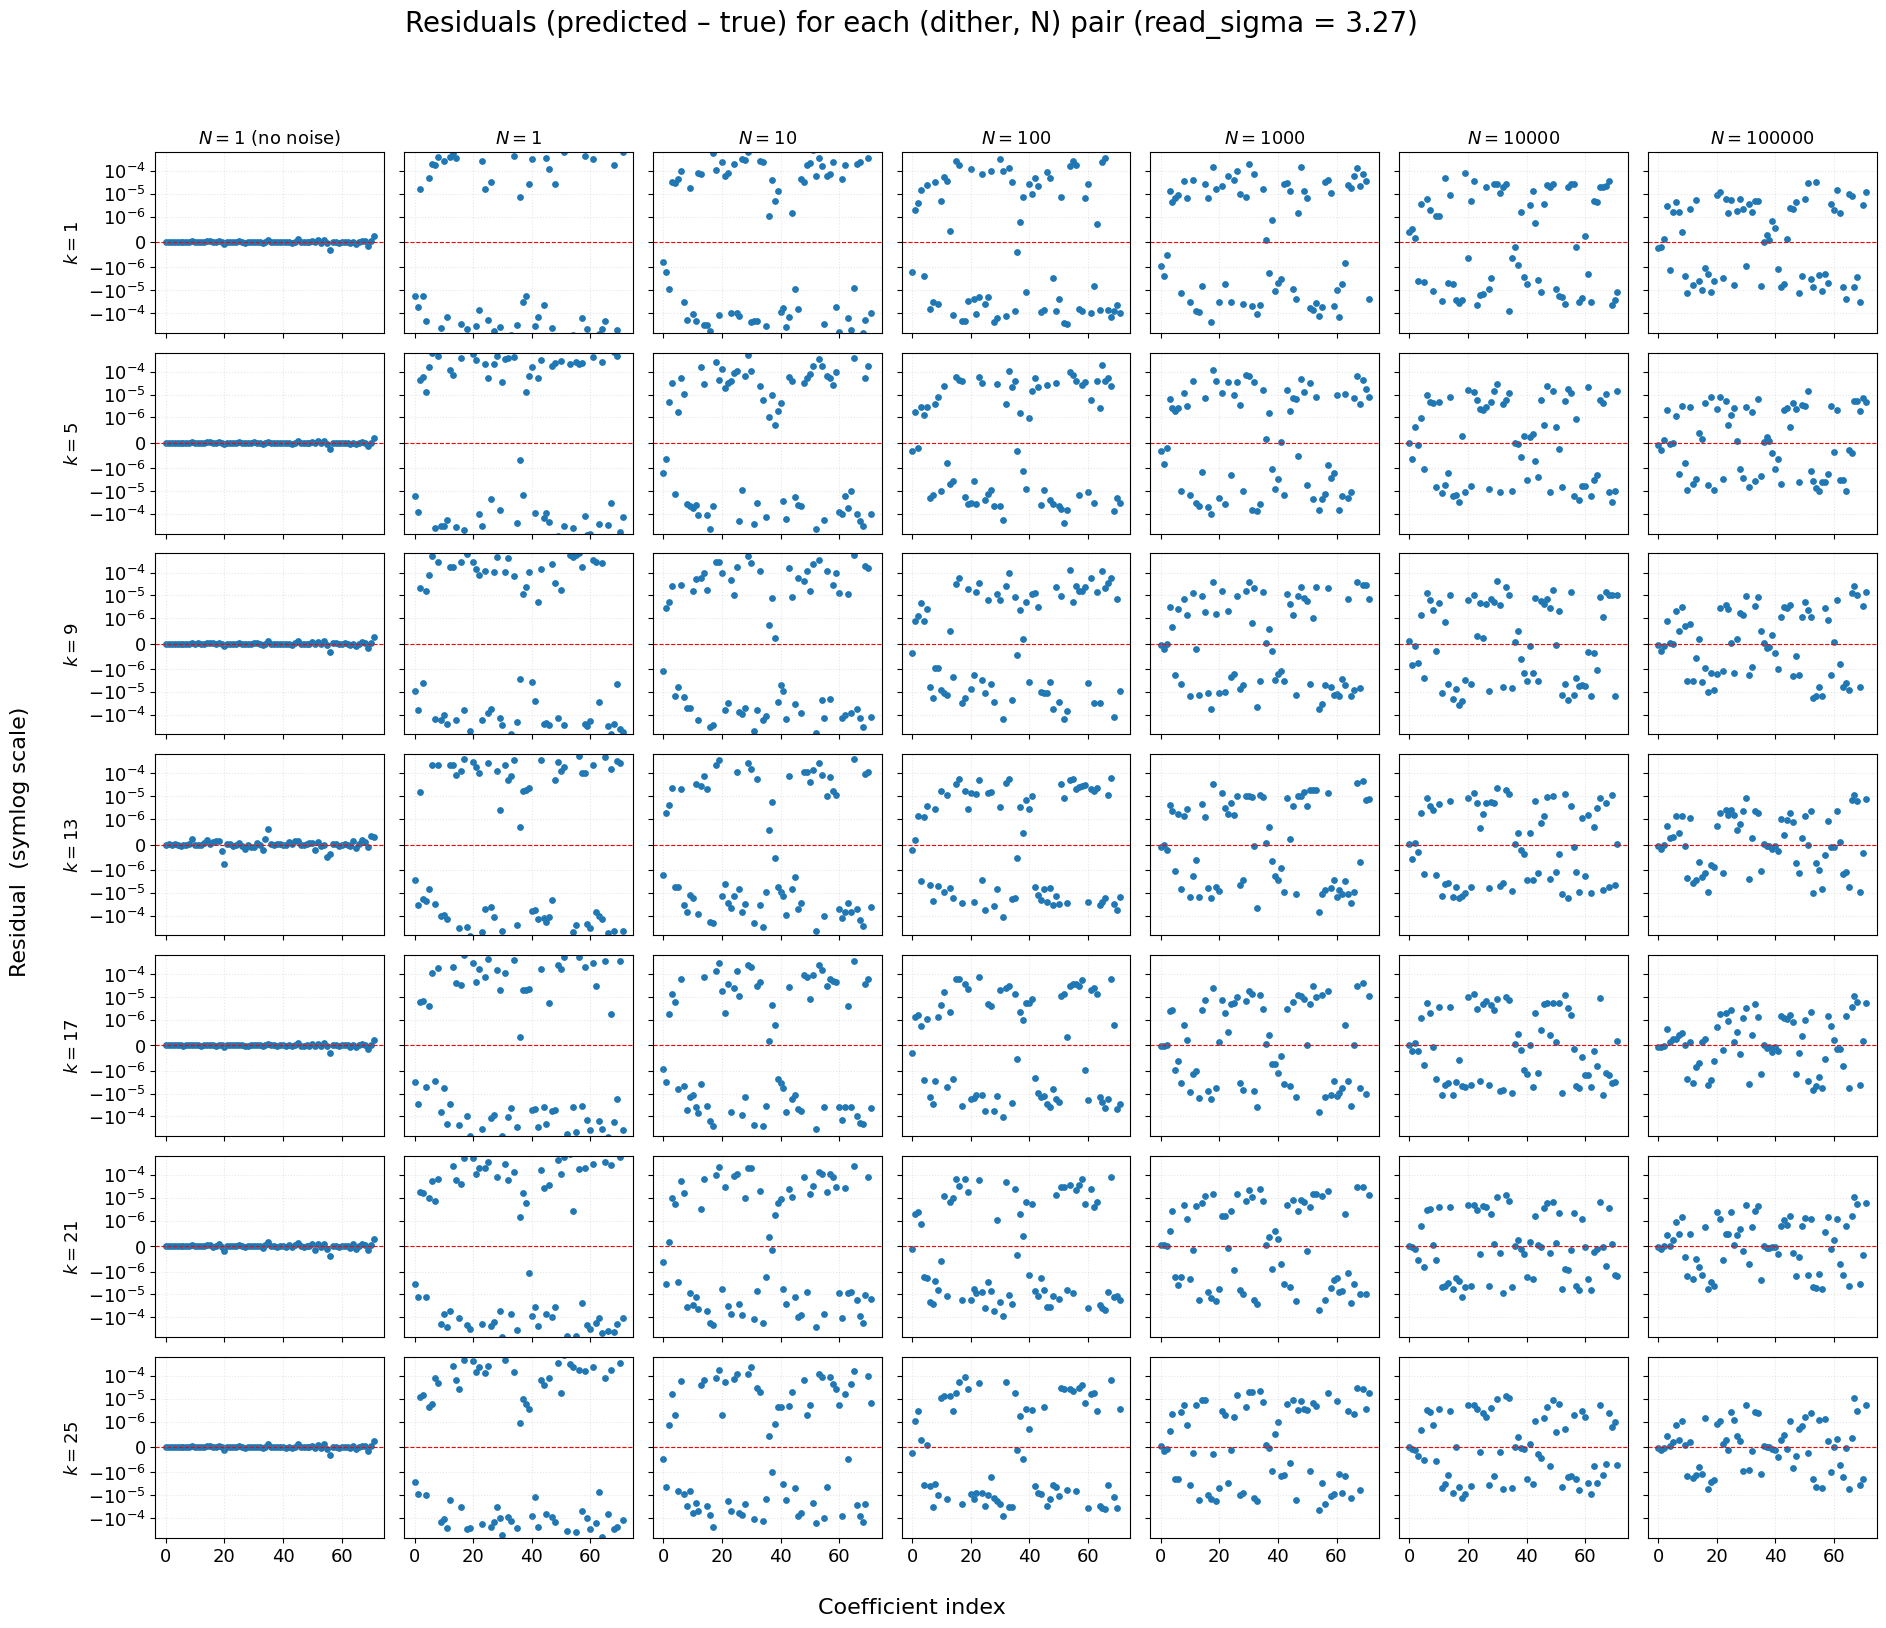

In [99]:
import numpy as np
import matplotlib.pyplot as plt

def plot_residual_grid(best_params_grid, true_params,
                       dither_list, N_list):
    """
    Draws a (len(dither_list)  ×  len(N_list)) grid of residual-scatter plots.

    Parameters
    ----------
    best_params_grid : list[list[np.ndarray]]
        best_params_grid[i][j] is the parameter vector recovered for
        dither index i and exposure index j.
    true_params      : array-like
        ground-truth coefficient array (length = 2 * n_terms).
    dither_list      : list[int]
        the k-dither values, e.g. [1, 5, 9, …].
    N_list           : list[int]
        the exposure counts, e.g. [0, 1, 10, …].
        The first entry (0) is assumed to be the “no-noise” column.
    """
    n_rows, n_cols = len(dither_list), len(N_list)
    true_vals = np.asarray(true_params)

    # ── global y-range (1–99 % central band + 10 % cushion) ───────────
    all_residuals = np.concatenate([
        np.asarray(best_params_grid[i][j]) - true_vals
        for i in range(n_rows) for j in range(n_cols)
    ])
    y_min, y_max = np.percentile(all_residuals, [1, 99])
    pad          = 0.1 * (y_max - y_min + 1e-12)
    y_lo, y_hi   = y_min - pad, y_max + pad

    # ── build labels for row/column headings ─────────────────────────
    xlabels = [r"$N = 1$ (no noise)"] + [fr"$N = {n}$" for n in N_list[1:]]
    ylabels = [fr"$k = {k}$" for k in dither_list]

    # ── plot grid ────────────────────────────────────────────────────
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(2.8*n_cols, 2.4*n_rows),
                             sharex=True, sharey=True)

    for i in range(n_rows):
        for j in range(n_cols):
            ax  = axes[i, j]
            res = np.asarray(best_params_grid[i][j]) - true_vals

            ax.scatter(np.arange(len(true_vals)), res,
                       s=15, color="tab:blue")
            ax.axhline(0.0, color="red", ls="--", lw=0.8)

            ax.set_ylim(y_lo, y_hi)
            ax.set_yscale("symlog", linthresh=1e-6)
            ax.grid(True, ls=":", alpha=0.3)
            ax.tick_params(axis='both', labelsize=13)

            # put column / row titles only once to avoid clutter
            if i == 0:
                ax.set_title(xlabels[j], fontsize=13, pad=6)
            if j == 0:
                ax.set_ylabel(ylabels[i], fontsize=13)

    fig.suptitle("Residuals (predicted – true) for each (dither, N) pair (read_sigma = 3.27)",
                 fontsize=20, y=0.995)
    fig.text(0.5, 0.04, "Coefficient index", ha='center', fontsize = 16)
    fig.text(0.04, 0.5, "Residual  (symlog scale)", va='center', rotation='vertical', fontsize = 16)
    plt.tight_layout(rect=[0.06, 0.06, 1, 0.96])
    plt.show()


# ─────────────────────────────────────────────────────────────
# call the helper
# ─────────────────────────────────────────────────────────────
plot_residual_grid(best_params_grid,
                   true_params=true_params,
                   dither_list=dither_list,
                   N_list=N_list)

# import numpy as np
# import matplotlib.pyplot as plt

# def plot_residual_grid_linear(best_params_grid, true_params,
#                               dither_list, N_list,
#                               tick_fontsize=13, title_fontsize=20,
#                               label_fontsize=16):
#     """
#     Scatter‐grid of residuals with *linear* y-axis and panel-wise limits.
#     """
#     n_rows, n_cols = len(dither_list), len(N_list)
#     true_vals = np.asarray(true_params)

#     # column / row headings
#     col_labels = [r"$N = 1$ (no noise)"] + [fr"$N = {n}$" for n in N_list[1:]]
#     row_labels = [fr"$k = {k}$" for k in dither_list]

#     fig, axes = plt.subplots(n_rows, n_cols,
#                              figsize=(2.8*n_cols, 2.4*n_rows),
#                              sharex=True, sharey=False)

#     for i in range(n_rows):
#         for j in range(n_cols):
#             ax  = axes[i, j]
#             res = np.asarray(best_params_grid[i][j]) - true_vals

#             # panel-specific y-range (1–99 % band + 10 % cushion)
#             y1, y2 = np.percentile(res, [1, 99])
#             pad    = 0.1 * (y2 - y1 + 1e-12)
#             ax.set_ylim(y1-pad, y2+pad)

#             ax.scatter(np.arange(len(true_vals)), res,
#                        s=15, color="tab:blue")
#             ax.axhline(0, color="red", ls="--", lw=0.8)

#             ax.grid(True, ls=":", alpha=0.3)
#             ax.tick_params(axis='both', labelsize=tick_fontsize)

#             if i == 0:
#                 ax.set_title(col_labels[j], fontsize=label_fontsize, pad=6)
#             if j == 0:
#                 ax.set_ylabel(row_labels[i], fontsize=label_fontsize)

#     fig.suptitle("Residuals (predicted – true) for each (dither, N) pair",
#                  fontsize=title_fontsize, y=0.995)
#     fig.text(0.5, 0.04, "Coefficient index", ha='center', fontsize=label_fontsize)
#     fig.text(0.04, 0.5, "Residual", va='center', rotation='vertical',
#              fontsize=label_fontsize)
#     plt.tight_layout(rect=[0.06, 0.06, 1, 0.95])
#     plt.show()


# # ─────────────────────────────────────────────────────────────
# # call the helper
# # ─────────────────────────────────────────────────────────────
# plot_residual_grid_linear(best_params_grid,
#                           true_params=true_params,
#                           dither_list=dither_list,
#                           N_list=N_list)


In [106]:
print("Index |        True Param        |     Predicted Param")
print("------|--------------------------|----------------------")
for i in range(len(true_params)):
    print(f"{i:4d}  |  {float(true_params[i]):+12.6e}  |  {float(best_params_grid[-1][-1][i]):+12.6e}")


Index |        True Param        |     Predicted Param
------|--------------------------|----------------------
   0  |  -2.058421e-05  |  -2.061865e-05
   1  |  -7.847658e-05  |  -7.858807e-05
   2  |  +1.816087e-04  |  +1.815639e-04
   3  |  +1.878440e-05  |  +1.922321e-05
   4  |  +8.086788e-06  |  +8.123725e-06
   5  |  -3.721108e-05  |  -3.703178e-05
   6  |  +1.190164e-04  |  +1.198665e-04
   7  |  +3.386423e-05  |  +3.412196e-05
   8  |  +8.482584e-06  |  +9.525648e-06
   9  |  -8.718178e-05  |  -8.709755e-05
  10  |  +1.054516e-04  |  +1.040376e-04
  11  |  -1.559498e-04  |  -1.557505e-04
  12  |  +3.675396e-05  |  +3.492170e-05
  13  |  +2.516352e-04  |  +2.503971e-04
  14  |  +2.585652e-05  |  +2.505359e-05
  15  |  -2.837104e-05  |  -2.952424e-05
  16  |  -5.338911e-05  |  -5.195207e-05
  17  |  +3.679477e-05  |  +3.159712e-05
  18  |  -1.959642e-05  |  -2.228323e-05
  19  |  +1.504077e-04  |  +1.482809e-04
  20  |  +5.904905e-06  |  +6.817072e-06
  21  |  +1.415813e-05  |  

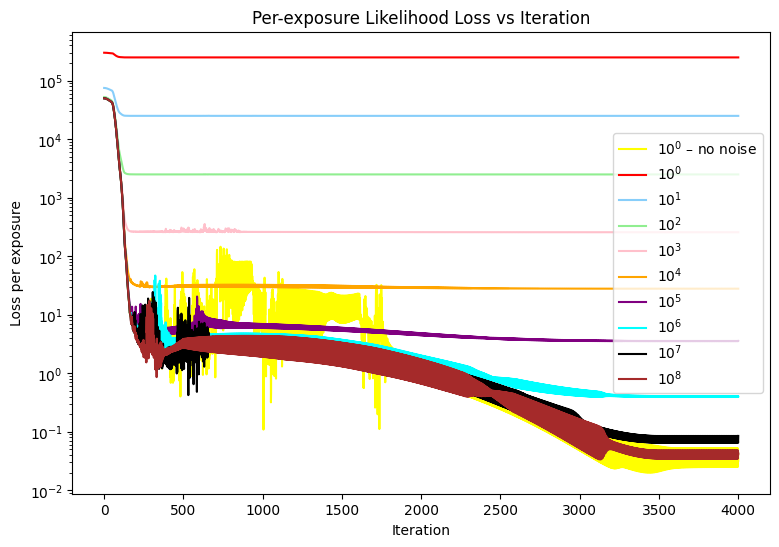

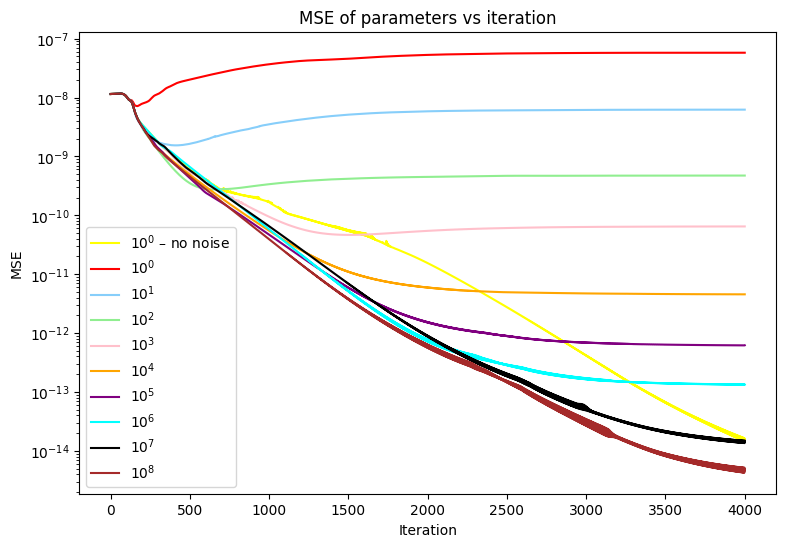

In [22]:
N_list = [1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]
def ten_pow_label(N: int) -> str:
    """Return '$10^{i}$' for N = 1,10,100,… ."""
    exp = int(np.round(np.log10(N)))
    return rf"$10^{{{exp}}}$"

per_exp_loss_histories = [
    [L / N for L in hist]          # divide every iteration’s loss by N
    for hist, N in zip(loss_history_list, N_list)
]

# --- plot ---
colors = ["yellow","red","lightskyblue","lightgreen",
          "pink","orange","purple", "cyan", "black", "brown"]

# ── per-exposure loss plot ───────────────────────────────────────
plt.figure(figsize=(9,6))
for idx, (hist, col, N) in enumerate(zip(per_exp_loss_histories, colors, N_list)):
    if idx == 0:
        lbl = r"$10^{0}$ – no noise"        # first curve
    else:
        lbl = ten_pow_label(N)
    plt.plot(hist, color=col, label=lbl)

plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss per exposure")
plt.title("Per-exposure Likelihood Loss vs Iteration")
plt.legend(); plt.show()

# ── parameter-MSE plot ───────────────────────────────────────────
plt.figure(figsize=(9,6))
for idx, (hist, col, N) in enumerate(zip(mse_history_list, colors, N_list)):
    lbl = r"$10^{0}$ – no noise" if idx == 0 else ten_pow_label(N)
    plt.plot(hist, color=col, label=lbl)

plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("MSE of parameters vs iteration")
plt.legend(); plt.show()


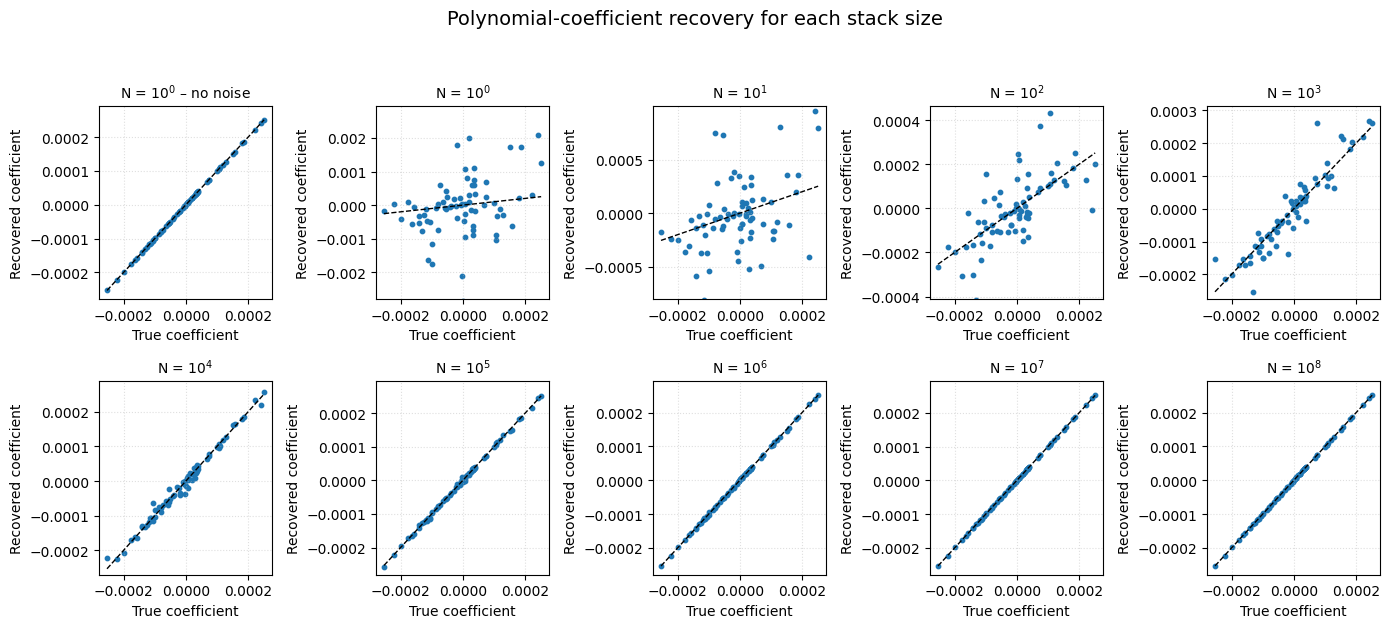

In [22]:
# Parameter Comparsion (Direct)
# true_vals = np.array(true_params)
# pred_vals = np.array(best_params_list[0])
# plt.figure()
# plt.scatter(true_vals, pred_vals)
# xmin, xmax = true_vals.min(), true_vals.max()
# ref_line = np.array([xmin, xmax])
# plt.plot(ref_line, ref_line)
# plt.xlabel("True Parameter")
# plt.ylabel("Recovered/Predicted Parameter")
# plt.title("Parameter Comparison")
# #plt.savefig("predicted_vs_true_order_7_new.png")
# plt.show()

# ---------------------------------------------------------------
# 2 × 5 grid : predicted-vs-true coefficients for every run
# ---------------------------------------------------------------
# ---------------------------------------------------------------
# one-to-one plots with per-panel auto-scaling
# ---------------------------------------------------------------

labels = [r"N = $10^{0}$ – no noise"] + [rf"N = $10^{{{k}}}$" for k in range(0,9)]
#labels.append(r"$10^{6}$")

true_vals = np.asarray(true_params)
xmin, xmax = true_vals.min(), true_vals.max()
ref_line   = np.array([xmin, xmax])

n_panels         = len(best_params_list)          # 10
n_rows, n_cols   = 2, 5
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(14, 6), sharex=False, sharey=False)

for ax, pred, lab in zip(axes.ravel(), best_params_list, labels):
    pred_vals = np.asarray(pred)
    ax.scatter(true_vals, pred_vals, s=10)
    ax.plot(ref_line, ref_line, 'k--', lw=1)

    # ---- set individual limits with 10 % padding ----
    y_min, y_max = np.percentile(pred_vals, [1, 99])     # robust range
    pad = 0.1 * (y_max - y_min + 1e-10)
    ax.set_ylim(y_min - pad, y_max + pad)

    ax.set_title(lab, fontsize=10)
    ax.grid(True, ls=":", alpha=0.4)
    ax.set_xlabel("True coefficient")
    ax.set_ylabel("Recovered coefficient")

fig.suptitle("Polynomial-coefficient recovery for each stack size",
             fontsize=14, y=1.04)
fig.tight_layout()
plt.show()



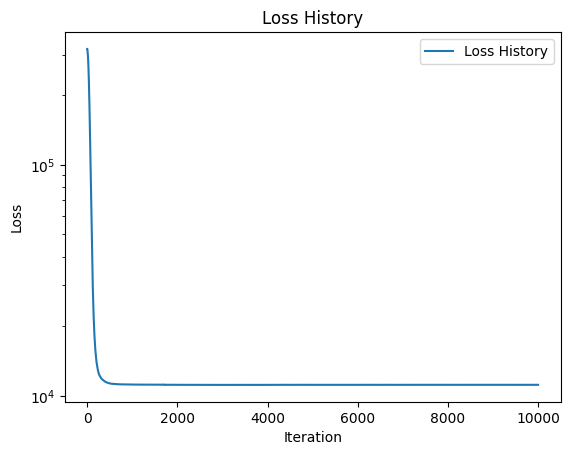

In [17]:
plt.plot(loss_history_list[1], label="Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss History")
plt.yscale("log")
plt.legend()
plt.show()

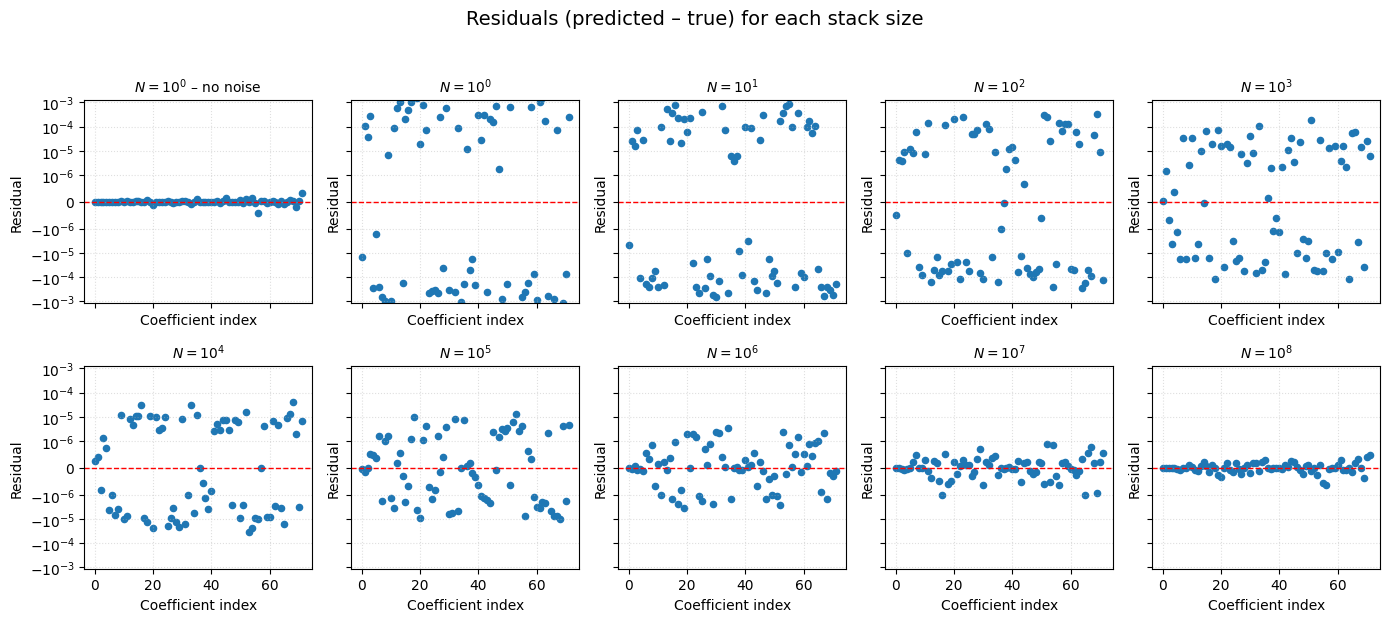

In [23]:
# # Parameter Comparison (Residuals)
# true_vals = np.array(true_params)
# pred_vals = np.array(best_params_list[0])
# residuals = pred_vals - true_vals
# plt.figure(figsize=(10, 6))
# plt.scatter(np.arange(len(true_vals)), residuals, color='blue', s=40)
# plt.axhline(0, color='red', linestyle='--', label="Zero Residual")
# plt.xlabel("Parameter Index", fontsize=14)
# plt.ylabel("Residual (Predicted - True)", fontsize=14)
# plt.title("Residual Plot of Distortion Parameters with Chi Squared", fontsize=16)
# plt.legend(fontsize=12)
# plt.grid(True)
# #plt.savefig("residual_vs_param_index_order_7_1e-5_new.png")
# plt.show()

# ---------------------------------------------------------------
# Residual ( pred – true ) of every coefficient, for every stack
# shown in a 2 × 5 grid with  N = 10^i  titles
# ---------------------------------------------------------------

# stack-size labels in the same order as best_params_list
labels = [r"$N = 10^{0}$ – no noise"] + [rf"$N = 10^{{{k}}}$" for k in range(0,9)]
assert len(labels) == len(best_params_list)         # safety

true_vals = np.asarray(true_params)

# ---------- compute a GLOBAL y-range ----------------------------
all_residuals = np.concatenate([
    np.asarray(pred) - true_vals
    for pred in best_params_list
])
y_min, y_max = np.percentile(all_residuals, [1, 99])
pad          = 0.1 * (y_max - y_min + 1e-12)        # 10 % cushion
y_lo, y_hi   = y_min - pad, y_max + pad
# ---------------------------------------------------------------

n_rows, n_cols = 2, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6),
                         sharex=True, sharey=True)   # sharey=True

for ax, pred, lab in zip(axes.ravel(), best_params_list, labels):
    residuals = np.asarray(pred) - true_vals

    ax.scatter(np.arange(len(true_vals)), residuals,
               s=20, color="tab:blue")
    ax.axhline(0.0, color="red", ls="--", lw=1)

    ax.set_ylim(y_lo, y_hi)                          # SAME LIMITS
    ax.set_yscale("symlog", linthresh=1e-6)
    ax.set_title(lab, fontsize=10)
    ax.grid(True, ls=":", alpha=0.4)
    ax.set_xlabel("Coefficient index")
    ax.set_ylabel("Residual")

fig.suptitle("Residuals (predicted – true) for each stack size",
             fontsize=14, y=1.03)
fig.tight_layout()
plt.show()


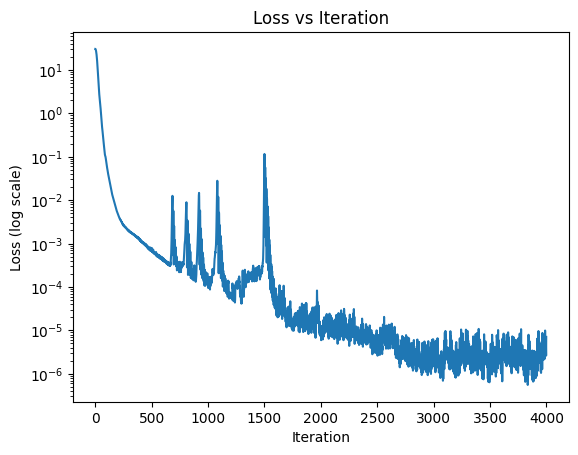

Text(0.5, 1.0, 'Parameter Values vs Iteration')

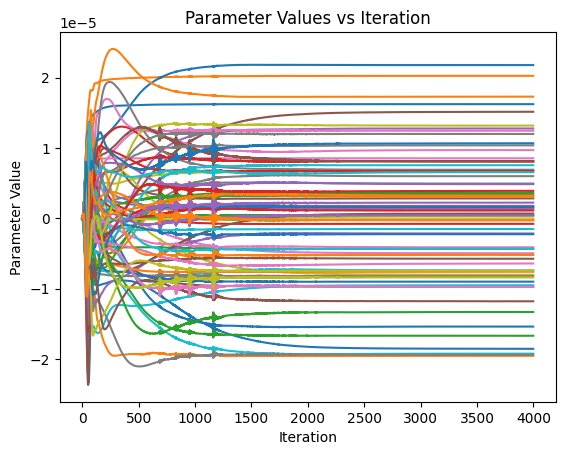

In [13]:
# Loss and Parameter Convergence
plt.figure()
plt.semilogy(loss_history_list[0])
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.title("Loss vs Iteration")
#lt.savefig("25_dither_loss_order_7.png")
plt.show()

plt.plot(params_list)
plt.xlabel("Iteration")
plt.ylabel("Parameter Value")
plt.title("Parameter Values vs Iteration")

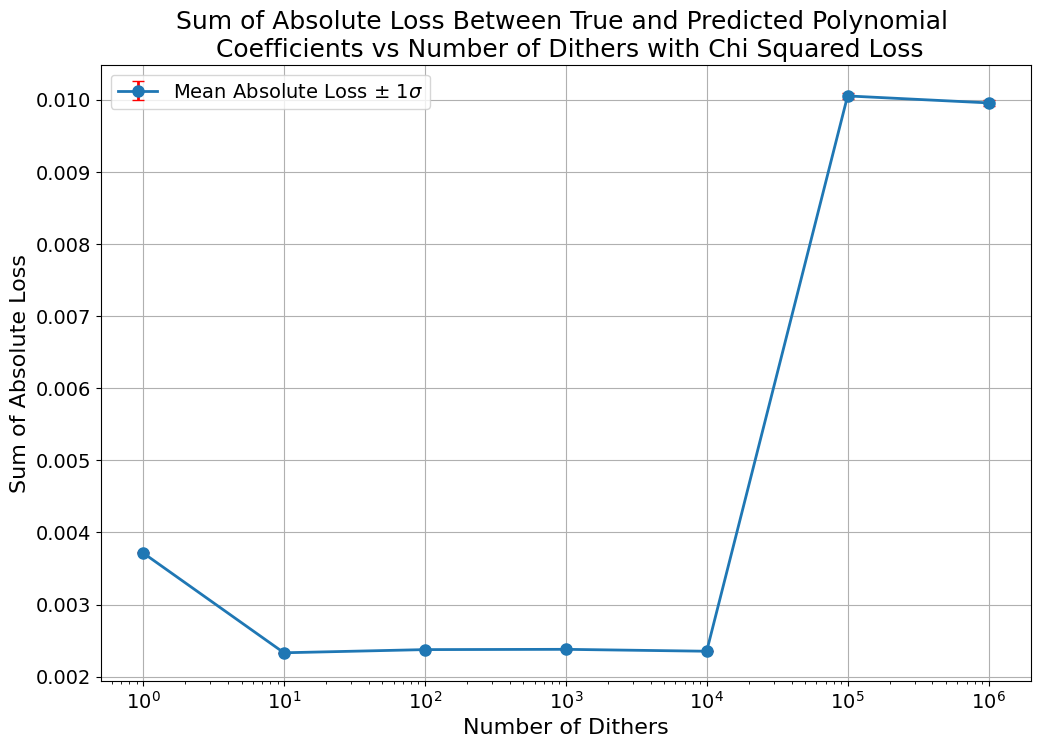

In [ ]:
# Loss vs Number of Dithers
#x = np.linspace(1, 4, 2)
x = [1, 10, 100, 1000, 10000, 100000, 1000000]
#x = [1, 10, 100, 1000]
plt.figure(figsize=(12, 8))

plt.errorbar(x,
    mismatch_mean_list,
    yerr=mismatch_std_list,
    fmt='o-',
    ecolor='red',
    capsize=4,
    linewidth=2,
    markersize=8
)
plt.xscale("log")
plt.xlabel("Number of Exposures", fontsize=16)
plt.ylabel("Sum of Absolute Loss", fontsize=16)
plt.title("Sum of Absolute Loss Between True and Predicted Polynomial \n Coefficients vs Number of Dithers with Chi Squared Loss", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend([r"Mean Absolute Loss $\pm$ 1$\sigma$"], fontsize=14)
#plt.savefig("absolute_loss_order_seven_vs_dithers_random_with_error_new.png")
plt.show()

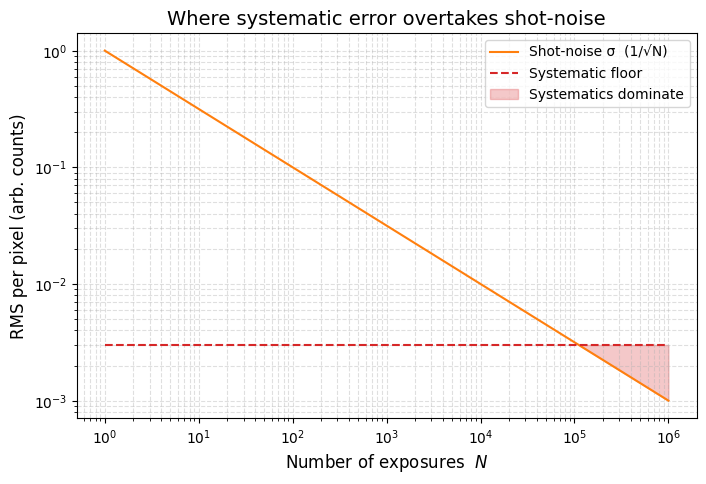

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# Parameters purely for demonstration
# -------------------------------------------------
lam_demo   = 1.0          # mean counts / pixel per exposure   (choose smaller)
floor_demo = 3e-3         # deterministic rms mismatch         (choose larger)

N_vals  = np.logspace(0, 6, 300)           # 1 … 1 000 000 exposures

shot_rms = np.sqrt(lam_demo / N_vals)      # statistical noise ∝ 1/√N
floor    = np.full_like(N_vals, floor_demo)

plt.figure(figsize=(8,5))
plt.loglog(N_vals, shot_rms, label="Shot-noise σ  (1/√N)", color="tab:orange")
plt.loglog(N_vals, floor,  "--",label="Systematic floor", color="tab:red")

cross = shot_rms < floor
plt.fill_between(N_vals, floor, shot_rms, where=cross,
                 color="tab:red", alpha=0.25, label="Systematics dominate")

plt.xlabel("Number of exposures  $N$", fontsize=12)
plt.ylabel("RMS per pixel (arb. counts)", fontsize=12)
plt.title("Where systematic error overtakes shot-noise", fontsize=14)
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()
plt.show()



In [ ]:
N = 100
pixel_scale = 0.375
coords = create_image_coords(N, pixel_scale)
order = 7
powers = get_polynomial_powers(order)
n_terms = len(powers)
det_pixsize = dlu.arcsec2rad(pixel_scale)
true_params = 1e-5 * jax.random.normal(jax.random.PRNGKey(0), shape=(2*n_terms,))

best_params_list = []
final_loss_list = []
loss_history_list = []
parameter_squared_loss_list = []
parameter_absolute_loss_list = []
mismatch_mean_list = []
mismatch_std_list = []
final_params_list = []

# key = jax.random.PRNGKey(713)
key = jax.random.PRNGKey(11)
#ks = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
ks = [0, 1]
#for k in tqdm(ks, desc="Outer Loop (Dither Count)", position=0):
for k in tqdm(range(1, 4, 2), desc="Outer Loop (Dither Count)", position=0):
    dither_offsets = get_dither_offsets_random(k, det_pixsize, r_factor=jnp.sqrt(3), key=key)
    print(dither_offsets)
    psfs = []
    for offset in dither_offsets:
        source = dlT.AlphaCen(
            n_wavels=3,
            separation=10.0,
            position_angle=90,
            x_position=offset[0],
            y_position=offset[1],
            log_flux=10,
            #log_flux=7.832,
            contrast=3.37,
            bandpass=(530, 640),
            weights=None
        )
        instrument = dlT.Toliman(optics, source)
        psf = instrument.model()
        psfs.append(psf)
    print(f"Number of PSFs for dither count {k}: {len(psfs)}")
    
    distorted_psfs = [sample_image_at_distorted_coords(psf, true_params, coords, powers) for psf in psfs]
    #distorted_psfs = [sample_image_at_distorted_coords(psf_smaller, true_params, coords, powers) for psf_smaller in psfs]
    distorted_psfs_data = []
    key = jr.PRNGKey(0)

    for distorted_psf in distorted_psfs:
        eps = k
        noise = eps * jnp.sqrt(distorted_psf) * jr.normal(jr.key(0), distorted_psf.shape)
        distorted_psfs_data.append(distorted_psf + noise)
    

    ideal_images = jnp.stack(psfs)
    distorted_images = jnp.stack(distorted_psfs_data)
    
    params, final_loss, loss_history, mismatch_mean, mismatch_std, final_params_arr, params_list = fit_polynomial_adam(
        ideal_images,
        distorted_images,
        coords,
        powers,
        learning_rate=1e-6,
        num_steps=501,
        avg_window=300,
        true_params = true_params
    )
    
    # import matplotlib as mpl

    # predicted_psf = sample_image_at_distorted_coords(psfs[0], params, coords, powers)
    # plt.figure(figsize=(6, 4))
    # plt.imshow(predicted_psf - distorted_psfs_data[0], norm=mpl.colors.CenteredNorm(), cmap="seismic")
    # plt.colorbar()
    # plt.title("Predicted PSF - Distorted PSF")
    # plt.show()

    # plt.figure(figsize=(6, 4))
    # plt.imshow(psfs[0] - distorted_psfs_data[0], norm=mpl.colors.CenteredNorm(), cmap="seismic")
    # plt.colorbar()
    # plt.title("Initial Predicted (True) PSF - Distorted PSF")
    # plt.show()

    # plt.figure(figsize=(6, 4))
    # plt.imshow(distorted_psfs[0], norm=mpl.colors.CenteredNorm(), cmap="seismic")
    # plt.colorbar()
    # plt.title("Distorted PSF")
    # plt.show()
    
    best_params_list.append(params)
    final_loss_list.append(final_loss)
    loss_history_list.append(loss_history)
    mismatch_mean_list.append(mismatch_mean)
    mismatch_std_list.append(mismatch_std)
    sq_loss, abs_loss = compute_parameter_loss(true_params, params)
    parameter_squared_loss_list.append(sq_loss)
    parameter_absolute_loss_list.append(abs_loss)
    final_params_list.append(final_params_arr)

In [30]:
key = jax.random.PRNGKey(11)
for k in tqdm(range(1, 26, 2), desc="Outer Loop (Dither Count)", position=0):
    dither_offsets = get_dither_offsets_random(k, det_pixsize, r_factor=jnp.sqrt(3), key=key)
    print(dither_offsets)

Outer Loop (Dither Count):   0%|          | 0/13 [00:00<?, ?it/s]

[[0. 0.]]
[[ 0.00000000e+00  0.00000000e+00]
 [-2.99353866e-07  2.64016299e-06]
 [ 1.93609761e-06  1.64052241e-06]]
[[ 0.00000000e+00  0.00000000e+00]
 [-2.99353866e-07  2.64016299e-06]
 [ 1.93609761e-06  1.64052241e-06]
 [ 3.03002029e-06 -2.24282157e-06]
 [-2.60369698e-06  4.77500616e-07]]
[[ 0.00000000e+00  0.00000000e+00]
 [-2.99353866e-07  2.64016299e-06]
 [ 1.93609761e-06  1.64052241e-06]
 [ 3.03002029e-06 -2.24282157e-06]
 [-2.60369698e-06  4.77500616e-07]
 [ 2.05369193e-06 -3.01426682e-06]
 [ 1.61263799e-06 -2.45882828e-06]]
[[ 0.00000000e+00  0.00000000e+00]
 [-2.99353866e-07  2.64016299e-06]
 [ 1.93609761e-06  1.64052241e-06]
 [ 3.03002029e-06 -2.24282157e-06]
 [-2.60369698e-06  4.77500616e-07]
 [ 2.05369193e-06 -3.01426682e-06]
 [ 1.61263799e-06 -2.45882828e-06]
 [-2.63045245e-06 -3.00755410e-06]
 [-1.88419229e-06  2.23257445e-06]]
[[ 0.00000000e+00  0.00000000e+00]
 [-2.99353866e-07  2.64016299e-06]
 [ 1.93609761e-06  1.64052241e-06]
 [ 3.03002029e-06 -2.24282157e-06]
 [-2.6

In [97]:
import pickle

# 1) gather everything into one dict
results = {
    "best_params_grid":    best_params_grid,
    "final_loss_grid":     final_loss_grid,
    "loss_history_grid":   loss_history_grid,
    "final_params_grid":   final_params_grid,
    "mse_history_grid":    mse_history_grid,
    "mismatch_mean_grid":  mismatch_mean_grid,
    "mismatch_std_grid":   mismatch_std_grid,
    "param_sq_loss_grid":  param_sq_loss_grid,
    "param_abs_loss_grid": param_abs_loss_grid,
    # you can also include your lists of N_list and dither_list
    "N_list":              N_list,
    "dither_list":         dither_list,
}

# 2) write to disk
with open("vary_exposure_and_dither_photon_noise_read_noise_3.7_LR_1e-5_TP_1e-4.pkl", "wb") as f:
    pickle.dump(results, f)

print("Saved all grids to fit_results.pkl")


Saved all grids to fit_results.pkl


In [93]:
with open("vary_exposure_and_dither_photon_noise_read_noise_5_LR_1e-5_TP_1e-4.pkl", "rb") as f:
    results = pickle.load(f)

hey_bbg   = results["best_params_grid"]

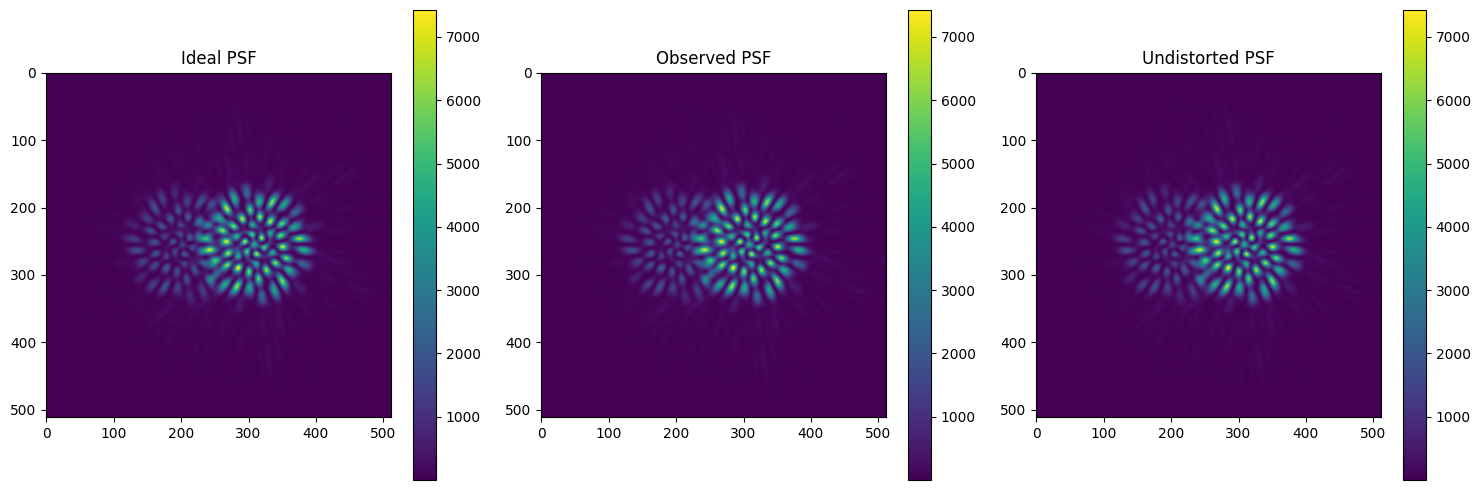

In [96]:
import jax
import jax.numpy as jnp
from jax.scipy.ndimage import map_coordinates

# -----------------------------------------------------------------------------
# 1. Shift-field utilities
# -----------------------------------------------------------------------------

def generate_random_pixel_shifts(npix: int,
                                 p: float,
                                 max_shift_pixels: float,
                                 key: jax.random.PRNGKey) -> jnp.ndarray:
    """Sparse per-pixel shifts: each pixel shifts with probability p by up to ±max_shift_pixels."""
    k_mask, k_x, k_y = jax.random.split(key, 3)
    mask = jax.random.bernoulli(k_mask, p, (npix, npix))
    sx   = jax.random.uniform(k_x, (npix, npix), minval=-max_shift_pixels, maxval=max_shift_pixels)
    sy   = jax.random.uniform(k_y, (npix, npix), minval=-max_shift_pixels, maxval=max_shift_pixels)
    return jnp.stack([sx * mask, sy * mask], axis=-1)

# -----------------------------------------------------------------------------
# 2. Forward warping / sampling
# -----------------------------------------------------------------------------

def sample_image_with_shifts(image: jnp.ndarray,
                             shifts_pix: jnp.ndarray,
                             pixel_scale: float,
                             order: int = 1) -> jnp.ndarray:
    """Warp image at sub-pixel shifts using bilinear interpolation."""
    npix = image.shape[-1]
    coords = jnp.arange(npix)
    centers = (coords - (npix - 1)/2) * pixel_scale
    gx, gy = jnp.meshgrid(centers, centers, indexing='xy')
    ix = (gx + shifts_pix[...,0]*pixel_scale) / pixel_scale + (npix-1)/2
    iy = (gy + shifts_pix[...,1]*pixel_scale) / pixel_scale + (npix-1)/2
    coords_flat = jnp.stack([iy.ravel(), ix.ravel()], axis=0)
    warped = map_coordinates(image, coords_flat, order=order, mode='reflect')
    return warped.reshape((npix, npix))

# -----------------------------------------------------------------------------
# 3. Horn–Schunck optical-flow recovery
#    (classic closed-form smooth-regularised solution)
# -----------------------------------------------------------------------------

def horn_schunck_shifts(ideal: jnp.ndarray,
                        observed: jnp.ndarray,
                        pixel_scale: float,
                        alpha: float = 0.2,
                        n_iters: int = 200) -> jnp.ndarray:
    """Horn–Schunck optical flow to estimate per-pixel sub-pixel shifts.
    Returns shifts array of shape (H, W, 2) in pixel units.

    alpha   – smoothness weight (higher ⇒ smoother field)
    n_iters – number of Jacobi iterations (200 is usually plenty)
    """
    # spatial gradients ∂I/∂x and ∂I/∂y of the ideal frame
    Ix = jnp.zeros_like(ideal)
    Iy = jnp.zeros_like(ideal)
    Ix = Ix.at[:, 1:-1].set((ideal[:, 2:] - ideal[:, :-2]) / (2*pixel_scale))
    Iy = Iy.at[1:-1, :].set((ideal[2:, :] - ideal[:-2, :]) / (2*pixel_scale))
    # temporal gradient (observed − ideal)
    It = observed - ideal

    # initial flow
    u = jnp.zeros_like(ideal)
    v = jnp.zeros_like(ideal)

    # helper: 4-neighbour average
    def avg(z):
        return 0.25 * (
            jnp.pad(z[1:,   :], ((0,1),(0,0))) +
            jnp.pad(z[:-1,  :], ((1,0),(0,0))) +
            jnp.pad(z[:, 1:], ((0,0),(0,1))) +
            jnp.pad(z[:, :-1], ((0,0),(1,0)))
        )

    for _ in range(n_iters):
        u_bar = avg(u)
        v_bar = avg(v)
        num = (Ix * u_bar + Iy * v_bar + It)
        den = alpha**2 + Ix**2 + Iy**2
        u = u_bar - Ix * num / den
        v = v_bar - Iy * num / den

    return jnp.stack([u, v], axis=-1)

# -----------------------------------------------------------------------------
# 4. Public API
# -----------------------------------------------------------------------------

def recover_pixel_shifts(ideal_psf: jnp.ndarray,
                         observed_psf: jnp.ndarray,
                         pixel_scale: float,
                         alpha: float = 0.1,
                         n_iters: int = 200) -> jnp.ndarray:
    """
    Wrapper for Horn–Schunck recovery with simplified signature.
    alpha   – smoothness weight (higher ⇒ smoother field)
    n_iters – number of Jacobi iterations
    """
    return horn_schunck_shifts(
        ideal_psf,
        observed_psf,
        pixel_scale,
        alpha=alpha,
        n_iters=n_iters
    )


# -----------------------------------------------------------------------
# -----------------------------------------------------------------------------
# 4. Example usage
# ----------------------------------------------------------------------------- Example usage
# -----------------------------------------------------------------------------
import dLuxToliman
optics = dLuxToliman.TolimanOpticalSystem(wf_npixels=256, psf_npixels=128, oversample=4)
src    = dLuxToliman.sources.AlphaCen(n_wavels=5, separation=10.)
tel    = dLuxToliman.telescopes.Toliman(optics, src)
ideal  = tel.model()                # (512,512)
npix   = ideal.shape[-1]

# simulate random sparse shifts
key          = jax.random.PRNGKey(0)
true_shifts  = generate_random_pixel_shifts(npix, p=0.25, max_shift_pixels=0.01, key=key)
pscale       = optics.psf_pixel_scale
obs          = sample_image_with_shifts(ideal, true_shifts, pscale)

# recover via smooth Adam
recov_shifts = recover_pixel_shifts(ideal, obs, pscale, n_iters=1, alpha = 10)
# undistort using NEGATIVE recovered shifts
undist       = sample_image_with_shifts(obs, recov_shifts, pscale)

# Diagnostics (example)
# import numpy as np, matplotlib.pyplot as plt
# print('Sum[(ideal-obs)²]=', np.sum((ideal-obs)**2))
# print('Sum[(ideal-undist)²]=', np.sum((ideal-undist)**2))
# plt.imshow(ideal-undist, origin='lower', interpolation='nearest'); plt.colorbar()
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Ideal PSF
im0 = axs[0].imshow(ideal)
axs[0].set_title("Ideal PSF")
fig.colorbar(im0, ax=axs[0])

# Observed PSF
im1 = axs[1].imshow(obs)
axs[1].set_title("Observed PSF")
fig.colorbar(im1, ax=axs[1])

# Undistorted PSF
im2 = axs[2].imshow(undist)
axs[2].set_title("Undistorted PSF")
fig.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()



In [265]:
import numpy as np

dx_ls      = np.load("dx_ls.npy")        # (128×128)
dy_ls      = np.load("dy_ls.npy")        # (128×128)
dr_ls      = np.load("dr_ls.npy")        # (128×128)
shift_det  = np.load("shift_det.npy")    # (128×128×2)
delta_rho  = np.load("delta_rho.npy")    # (128×128)
ideal      = np.load("ideal.npy")        # (4001×128×128)
arcsec_det = float(np.load("arcsec_det.npy"))  # scalar

dx_ls

/var/folders/s5/2h1mpzqd4yvdmq6dzdkqcpl40000gn/T/ipykernel_26543/3327890064.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  arcsec_det = float(np.load("arcsec_det.npy"))  # scalar


array([[-0.00201359,  0.00251172, -0.00628711, ...,  0.00915449,
        -0.0003252 ,  0.00639265],
       [-0.00245086,  0.00280593, -0.00495823, ...,  0.00670699,
         0.00245139,  0.0025136 ],
       [-0.02138859, -0.01074386, -0.00274583, ..., -0.00350373,
         0.00163332, -0.00082974],
       ...,
       [-0.00919763,  0.0016355 , -0.00444659, ...,  0.00094843,
         0.00123646,  0.00033636],
       [ 0.00906669, -0.00812564,  0.01162303, ...,  0.00607774,
        -0.00941599, -0.00129024],
       [ 0.02388795,  0.00520317, -0.01042423, ..., -0.008414  ,
         0.00010284,  0.01261575]], shape=(128, 128))

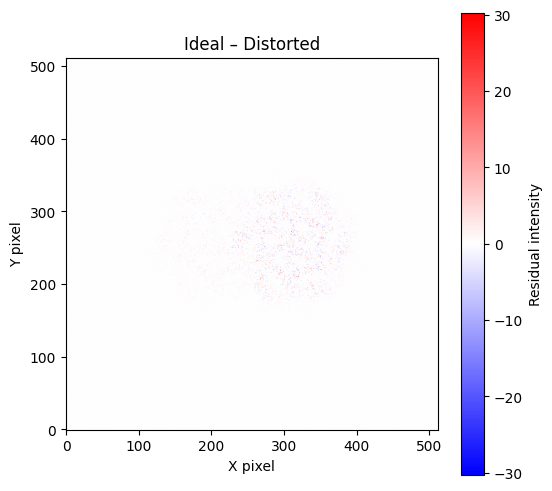

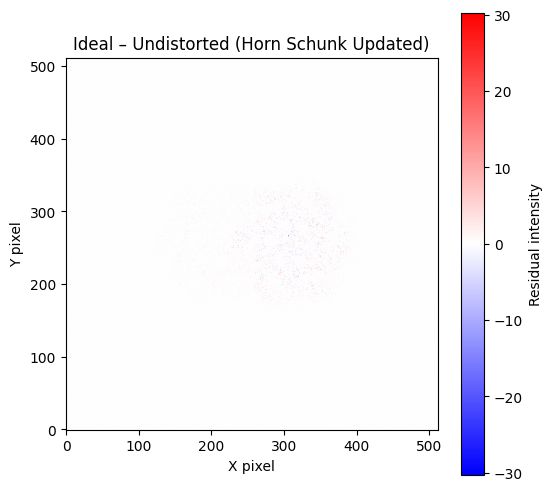

Total error (ideal–obs)        = 55480.11
std deviation (ideal–obs)      = 0.46004316
Total error (ideal–undist)     = 23937.977
std deviation (ideal–undist)   = 0.30218488


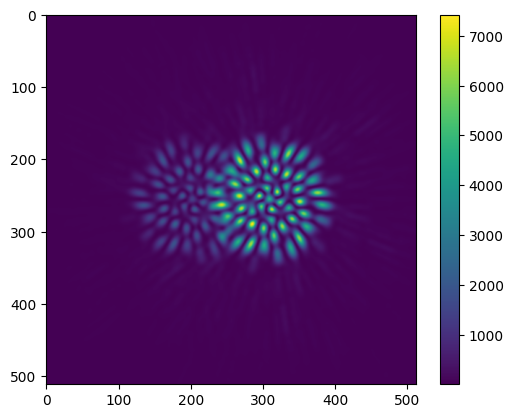

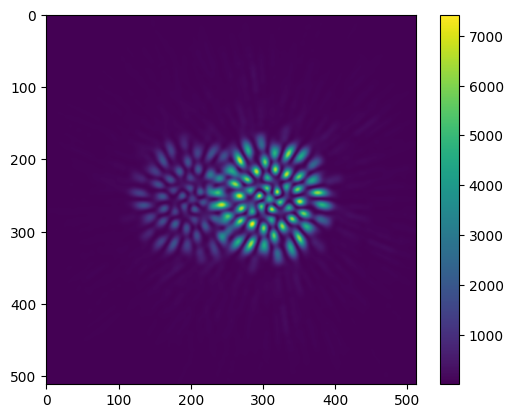

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# assume `ideal`, `obs`, and `undist` are your image arrays

# 1) compute the two residual images (convert to NumPy if needed)
diff1 = np.array(ideal) - np.array(obs)
diff2 = np.array(ideal) - np.array(undist)

# 2) find the largest absolute residual across both
max_abs = max(np.abs(diff1).max(), np.abs(diff2).max())

# 3) create a diverging norm centered at zero
norm = TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=+max_abs)

# 4) first plot: Ideal – Distorted
plt.figure(figsize=(6,6))
plt.imshow(diff1,
           origin='lower',
           cmap='bwr',
           norm=norm)
plt.colorbar(label='Residual intensity')
plt.title("Ideal – Distorted")
plt.xlabel("X pixel")
plt.ylabel("Y pixel")
plt.show()

# 5) second plot: Ideal – Undistorted
plt.figure(figsize=(6,6))
plt.imshow(diff2,
           origin='lower',
           cmap='bwr',
           norm=norm)
plt.colorbar(label='Residual intensity')
plt.title("Ideal – Undistorted (Horn Schunk Updated)")
plt.xlabel("X pixel")
plt.ylabel("Y pixel")
plt.show()

print("Total error (ideal–obs)        =", np.sum(diff1**2))
print("std deviation (ideal–obs)      =", np.std(diff1))
print("Total error (ideal–undist)     =", np.sum(diff2**2))
print("std deviation (ideal–undist)   =", np.std(diff2))

plt.imshow(ideal)
plt.colorbar()
plt.show()

plt.imshow(obs)
plt.colorbar()
plt.show()

In [353]:
errs = []
stds = []
for i in trange(1000):
    
    recov_shifts = recover_pixel_shifts(ideal, obs, pscale,
                                    lr=0.1, n_iters=i,
                                    reg_l2=1e-4, reg_smooth=1e-2,
                                    clip_norm=1.0)

    undist = sample_image_with_shifts(obs, recov_shifts, pscale)
    diff = ideal - undist
    error = np.sum(diff**2)
    std = np.std(diff)
    errs.append(error)
    stds.append(std)


  0%|          | 0/1000 [00:00<?, ?it/s]

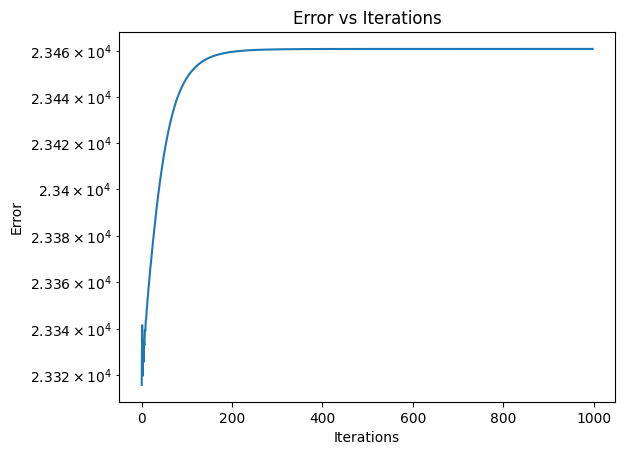

In [358]:
plt.plot(errs[1:])
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title("Error vs Iterations")
plt.yscale("log")


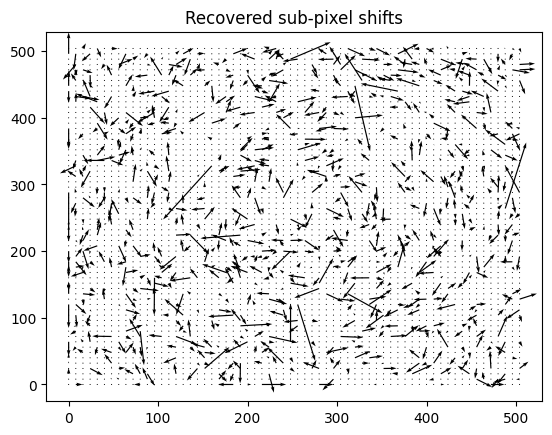

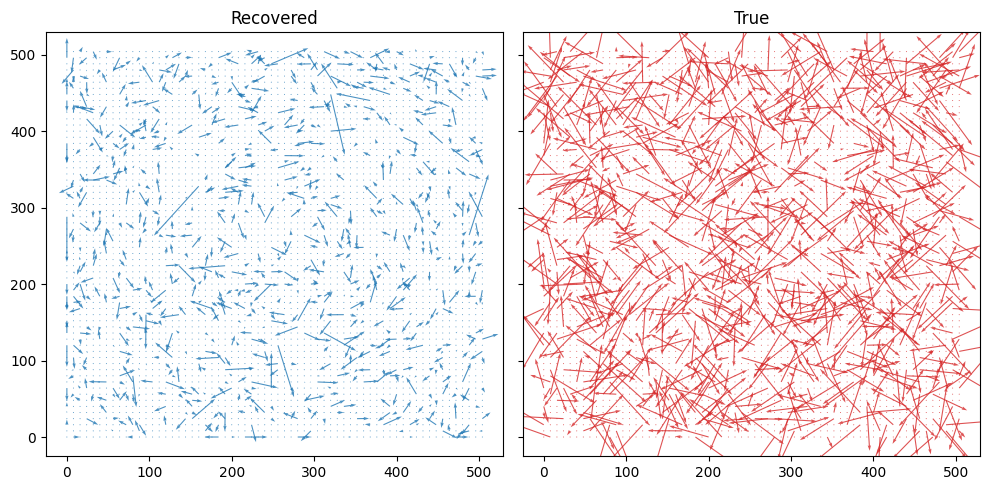

In [383]:
step = 8
X, Y = np.meshgrid(np.arange(0,npix,step), np.arange(0,npix,step))
U = recov_shifts[::step, ::step, 0]
V = recov_shifts[::step, ::step, 1]
plt.quiver(X, Y, U, V, scale=0.1)   # scale tweaks arrow length
plt.title("Recovered sub-pixel shifts")
#plt.gca().invert_yaxis()


# assume true_shifts has shape (npix,npix,2)
U_true = true_shifts[::step, ::step, 0]
V_true = true_shifts[::step, ::step, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
ax1.quiver(X, Y, U, V, scale=0.1, color='C0', alpha=0.8)
ax1.set_title("Recovered")
#ax1.invert_yaxis()
ax2.quiver(X, Y, U_true, V_true, scale=0.1, color='C3', alpha=0.8)
ax2.set_title("True")
#ax2.invert_yaxis()
plt.tight_layout()



In [ ]:
# ==============================================================
# Per-pixel gradient solve – units reconciled
# ==============================================================

import numpy as np
from scipy.ndimage import map_coordinates
import dLuxToliman
import matplotlib as mpl
import dLux.utils as dlu
from global_polynomial_functions import (
    get_dither_offsets_uniform,
    get_dither_offsets_random
)

# ───────────── helper functions ───────────────────────────────
def central_grad(img, arcsec_per_sup_px):
    """Finite diff; output slope per arc-second."""
    gx = np.zeros_like(img); gy = np.zeros_like(img)
    gx[:,1:-1] = (img[:,2:] - img[:,:-2]) / (2*arcsec_per_sup_px)
    gy[1:-1,:] = (img[2: ,:] - img[:-2,:]) / (2*arcsec_per_sup_px)
    return gx, gy

def warp(img, field_sup, order=2):
    """Warp by field (Δx,Δy) in *super-pixels*."""
    dy, dx = field_sup[...,1], field_sup[...,0]
    y,x = np.indices(img.shape)
    return map_coordinates(img, [y-dy, x-dx], order=order, mode='reflect')

def rand_field(npix, p, amp_det_px, rng, ovsp):
    """Sparse ±amp detector-px → super-px field."""
    m   = rng.random((npix,npix)) < p
    sx  = rng.uniform(-amp_det_px, amp_det_px, (npix,npix))*m
    sy  = rng.uniform(-amp_det_px, amp_det_px, (npix,npix))*m
    return np.stack([sx,sy],-1)            # super-px units

# ───────────── 1. optics & scale factors ──────────────────────
opt        = dLuxToliman.TolimanOpticalSystem(wf_npixels=256,
                                              psf_npixels=128,
                                              oversample=4)
ovsp       = opt.oversample 
print(ovsp)                 # 4
arcsec_det = opt.psf_pixel_scale             # ″ per detector-px  (≈ 0.375″)
arcsec_sup = arcsec_det / ovsp 
#det_pixel_size = arcsec_sup             # ″ per super-px     (≈ 0.0938″)
H = W = opt.psf_npixels * ovsp              # 512

# ───────────── 2. five-point dither pattern ──────────────────
dith_det_px = [(0,0),(+0.2,0),(-0.2,0),(0,+0.2),(0,-0.2), (+0.1, 0), (-0.1, 0), (0, +0.1), (0, -0.1)]
#dith_det_px = [(0,0)]
dith_arc_new   = [(dx*arcsec_det, dy*arcsec_det) for dx,dy in dith_det_px]
#dith_arc_new = get_dither_offsets_uniform(101, det_pixel_size, r_factor=jnp.sqrt(3))
#dith_arc_new = get_dither_offsets_random(101, det_pixel_size, r_factor=jnp.sqrt(3), key=jax.random.PRNGKey(0))
n_dith      = len(dith_det_px)

# ───────────── 3. ideal PSFs + gradients ─────────────────────
ideal, gx, gy = [], [], []
for x_arc, y_arc in dith_arc_new:
    src = dLuxToliman.sources.AlphaCen(n_wavels=5, separation=10.,
                                       position_angle=90,
                                       x_position=x_arc, y_position=y_arc)
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    im  = np.asarray(tel.model())           # (512,512)
    ideal.append(im)
    gxi, gyi = central_grad(im, arcsec_sup)
    gx.append(gxi); gy.append(gyi)

ideal = np.stack(ideal);  gx = np.stack(gx);  gy = np.stack(gy)

# ───────────── 4. sparse pixel distortion (25 %, ±0.01 det-px) ─
rng   = np.random.default_rng(0)
field_sup = rand_field(H, p=0.25, amp_det_px=0.01 * ovsp, rng=rng, ovsp=ovsp)
# ───────────── 5. distorted cube ─────────────────────────────
dist = np.stack([warp(im, field_sup) for im in ideal])

# ───────────── 6. per-pixel LS solve (ridge λ) ───────────────
lam = 1e-4
Δx_arc = np.zeros((H,W));  Δy_arc = np.zeros((H,W))

for j in range(H):
    Gx = gx[:,j,:]; Gy = gy[:,j,:]
    R  = ideal[:,j,:] - dist[:,j,:]
    A11 = np.sum(Gx*Gx,0)+lam;  A22 = np.sum(Gy*Gy,0)+lam
    A12 = np.sum(Gx*Gy,0)
    det = A11*A22 - A12*A12 + 1e-12
    b1  = np.sum(Gx*R,0);      b2  = np.sum(Gy*R,0)
    Δx_arc[j]=(A22*b1-A12*b2)/det
    Δy_arc[j]=(A11*b2-A12*b1)/det

# convert arc-sec → super-pixel for warping
est_sup = np.dstack([Δx_arc/arcsec_sup, Δy_arc/arcsec_sup])

# ───────────── 7. correct on-axis frame ──────────────────────
undist = warp(dist[0], -est_sup)

# ───────────── 8. diagnostics ───────────────────────────────
chi_dist = np.sum((ideal[0]-dist[0])**2)
chi_corr = np.sum((ideal[0]-undist )**2)
print(f"χ² distorted : {chi_dist:,.0f}")
print(f"χ² corrected : {chi_corr:,.0f}")

# plt.imshow((ideal[0]-dist[0]), cmap="seismic", norm=mpl.colors.CenteredNorm())
# plt.colorbar()
# plt.title("Ideal – Distorted")
# plt.show()

# plt.imshow((ideal[0]-undist), cmap="seismic", norm=mpl.colors.CenteredNorm())
# plt.colorbar()
# plt.title("Ideal – Undistorted")
# plt.show()

# shift_det      = field_sup / ovsp       # true   Δx,Δy in *detector* px
# shift_est_det  = est_sup   / ovsp       # solved Δx,Δy in detector px

# # Binary mask of pixels that were actually shifted (use any() on last axis)
# mask = np.any(field_sup != 0.0, axis=-1)

# def stats(arr, m=None):
#     """Return mean(|dx|), mean(|dy|), mean radial shift."""
#     if m is not None:
#         arr = arr[m]
#     dx, dy = arr[..., 0], arr[..., 1]
#     mean_dx = np.mean(np.abs(dx))
#     mean_dy = np.mean(np.abs(dy))
#     mean_r  = np.mean(np.sqrt(dx**2 + dy**2))
#     return mean_dx, mean_dy, mean_r

# # -- imposed field
# mx_all, my_all, mr_all   = stats(shift_det)
# mx_act, my_act, mr_act   = stats(shift_det, mask)

# # -- recovered field
# mx_est, my_est, mr_est   = stats(shift_est_det, mask)

# print("\n――― mean shift per pixel (det-px units) ―――")
# print(f"TRUE  (all px) : ⟨|Δx|⟩={mx_all:.5f}  ⟨|Δy|⟩={my_all:.5f}  ⟨r⟩={mr_all:.5f}")
# print(f"TRUE  (active) : ⟨|Δx|⟩={mx_act:.5f}  ⟨|Δy|⟩={my_act:.5f}  ⟨r⟩={mr_act:.5f}")
# print(f"RECOV (active) : ⟨|Δx|⟩={mx_est:.5f}  ⟨|Δy|⟩={my_est:.5f}  ⟨r⟩={mr_est:.5f}\n")



# flux_ideal = np.sum(ideal[0])
# flux_dist  = np.sum(dist[0])
# print(f"Total flux    (ideal) : {flux_ideal:.6e}")
# print(f"Total flux (distorted): {flux_dist :.6e}")
# print(f"Relative change       : {(flux_dist/flux_ideal -1)*100:.3e} %")

4
χ² distorted : 881,606
χ² corrected : 648


χ² distorted : 3,704,020
χ² corrected : 1,767


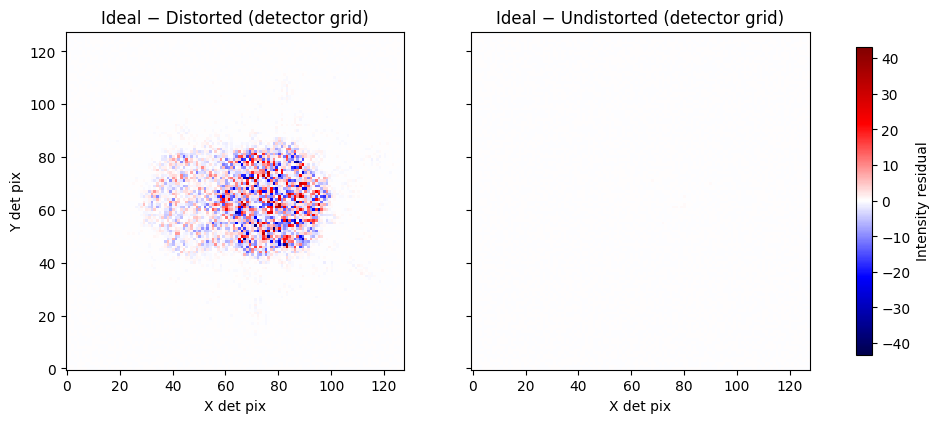


――― mean shift per pixel (det-px units) ―――
TRUE  (all px): ⟨|Δx|⟩=0.00502  ⟨|Δy|⟩=0.00496  ⟨r⟩=0.00764
TRUE  (active): ⟨|Δx|⟩=0.00502  ⟨|Δy|⟩=0.00496  ⟨r⟩=0.00764
RECOV (active): ⟨|Δx|⟩=0.00498  ⟨|Δy|⟩=0.00492  ⟨r⟩=0.00758



In [263]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacfwd, vmap
from scipy.ndimage import map_coordinates
import dLuxToliman

import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm

# ───────────── helper functions ───────────────────────────────
def warp(img, field_sup, order=2):
    dy, dx = field_sup[...,1], field_sup[...,0]
    y, x   = np.indices(img.shape)
    return map_coordinates(img, [y - dy, x - dx], order=order, mode="reflect")

def rand_field(H, p, amp_det_px, rng):
    m  = rng.random((H, H)) < p
    sx = rng.uniform(-amp_det_px, amp_det_px, (H, H)) * m
    sy = rng.uniform(-amp_det_px, amp_det_px, (H, H)) * m
    return np.stack([sx, sy], axis=-1)

def downsample(img, factor):
    """Average over non-overlapping factor×factor blocks"""
    h, w = img.shape
    return img.reshape(h//factor, factor, w//factor, factor).mean(axis=(1,3))

# ───────────── 1) Optics & scales ─────────────────────────────
opt        = dLuxToliman.TolimanOpticalSystem(
                wf_npixels=256, psf_npixels=128, oversample=4)
ovsp       = opt.oversample
arcsec_det = opt.psf_pixel_scale     # ″ per detector-px
arcsec_sup = arcsec_det / ovsp       # ″ per super-px

# ───────────── 2) Dither pattern ─────────────────────────────
dith_det_px = [
    ( 0.0,  0.0), (+0.2,  0.0), (-0.2,  0.0),
    ( 0.0, +0.2), ( 0.0, -0.2)
]
dith_arcsec = jnp.array([
    (dx * arcsec_det, dy * arcsec_det)
    for dx, dy in dith_det_px
])  # (K,2)
K = dith_arcsec.shape[0]

# ───────────── 3) PSF generator + autodiff ───────────────────
def psf_from_tilt(tt: jnp.ndarray) -> jnp.ndarray:
    dx, dy = tt
    src = dLuxToliman.sources.AlphaCen(
        n_wavels=5, separation=10.0, position_angle=90.0,
        x_position=dx, y_position=dy
    )
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    return tel.model()  # (H_img, W_img)

# vectorize PSF calls
ideal_jax = vmap(psf_from_tilt)(dith_arcsec)      # (K, H, W)
grad_fn   = jacfwd(psf_from_tilt)
grads_jax = vmap(grad_fn)(dith_arcsec)            # (K, H, W, 2)

# split into Gx, Gy by last axis
Gx_jax = grads_jax[..., 0]  # (K, H, W)
Gy_jax = grads_jax[..., 1]  # (K, H, W)

# convert to NumPy
ideal = np.asarray(ideal_jax)  # (K, H, W)
gx    = np.asarray(Gx_jax)     # (K, H, W)
gy    = np.asarray(Gy_jax)     # (K, H, W)

# ───────────── 4) Sparse random warp ────────────────────────
H_img, W_img = ideal.shape[1:]
rng          = np.random.default_rng(0)
#field_sup    = rand_field(H_img, p=0.25, amp_det_px=0.01 * ovsp, rng=rng)
# 1) make a mask at 128×128 detector pixels
mask_det = rng.random((opt.psf_npixels, opt.psf_npixels)) < 1.0

# 2) draw shifts in detector-pixel units ±0.01
shift_det = rng.uniform(-0.01, 0.01,
                        size=(opt.psf_npixels,
                              opt.psf_npixels,
                              2)) * mask_det[...,None]

# 3) broadcast to super-pixels (so each 4×4 block is the same shift)
field_sup = np.kron(shift_det * ovsp,   # convert det-px→sup-px
                    np.ones((ovsp, ovsp, 1)))
# field_sup.shape == (512, 512, 2)

dist         = np.stack([warp(im, field_sup) for im in ideal])  # (K, H, W)

# ───────────── 5) Vectorized LS solve ───────────────────────
lam = 1e-4
R   = ideal - dist  # (K, H, W)

A11 = np.sum(gx * gx, axis=0) + lam
A22 = np.sum(gy * gy, axis=0) + lam
A12 = np.sum(gx * gy, axis=0)

b1  = np.sum(gx * R,  axis=0)
b2  = np.sum(gy * R,  axis=0)

det   = A11 * A22 - A12 * A12 + 1e-12
x_arc = (A22 * b1 - A12 * b2) / det
y_arc = (A11 * b2 - A12 * b1) / det

# ───────────── 6) Deblur ───────────────────────────────────
est_sup = np.stack([x_arc / arcsec_sup,
                    y_arc / arcsec_sup], axis=-1)  # (H_img, W_img, 2)
undist  = warp(dist[0], est_sup)

chi_dist = np.sum((ideal[0] - dist[0])**2)
chi_corr = np.sum((ideal[0] - undist )**2)
print(f"χ² distorted : {chi_dist:,.0f}")
print(f"χ² corrected : {chi_corr:,.0f}")

# ───────────── 7) Downsample to detector grid ─────────────
est_det = est_sup.reshape(
    opt.psf_npixels, ovsp,
    opt.psf_npixels, ovsp,
    2
).mean(axis=(1,3))  # (128,128,2) super-px units
shift_est_det = est_det / ovsp         # (128,128,2) detector px

field_det   = field_sup.reshape(
    opt.psf_npixels, ovsp,
    opt.psf_npixels, ovsp,
    2
).mean(axis=(1,3))
shift_true_det = field_det / ovsp       # (128,128,2)
mask_det     = np.any(field_det != 0.0, axis=-1)

# downsample PSFs & residuals to 128×128 detector grid
ideal_det  = downsample(ideal[0], ovsp)
dist_det   = downsample(dist[0],  ovsp)
undist_det = downsample(undist,   ovsp)

res1 = ideal_det  - dist_det
res2 = ideal_det  - undist_det

# ───────────── 8) Residual plots ───────────────────────────
vmax = max(abs(res1).max(), abs(res2).max())
norm = CenteredNorm(vcenter=0.0, halfrange=vmax)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
im = ax1.imshow(res1, origin='lower', cmap='seismic', norm=norm, interpolation='nearest')
ax1.set_title("Ideal − Distorted (detector grid)")
ax1.set_xlabel("X det pix")
ax1.set_ylabel("Y det pix")
ax2.imshow(res2, origin='lower', cmap='seismic', norm=norm, interpolation='nearest')
ax2.set_title("Ideal − Undistorted (detector grid)")
ax2.set_xlabel("X det pix")
fig.colorbar(im, ax=[ax1, ax2], shrink=0.8, label="Intensity residual")
plt.show()

# ───────────── 9) Stats on detector grid ───────────────────
def stats(arr, m=None):
    if m is not None:
        arr = arr[m]
    dx, dy = arr[...,0], arr[...,1]
    return np.mean(np.abs(dx)), np.mean(np.abs(dy)), np.mean(np.hypot(dx, dy))

mx_true, my_true, mr_true = stats(shift_true_det)
mx_act,  my_act,  mr_act  = stats(shift_true_det, mask_det)
mx_est,  my_est,  mr_est  = stats(shift_est_det, mask_det)

print("\n――― mean shift per pixel (det-px units) ―――")
print(f"TRUE  (all px): ⟨|Δx|⟩={mx_true:.5f}  ⟨|Δy|⟩={my_true:.5f}  ⟨r⟩={mr_true:.5f}")
print(f"TRUE  (active): ⟨|Δx|⟩={mx_act:.5f}  ⟨|Δy|⟩={my_act:.5f}  ⟨r⟩={mr_act:.5f}")
print(f"RECOV (active): ⟨|Δx|⟩={mx_est:.5f}  ⟨|Δy|⟩={my_est:.5f}  ⟨r⟩={mr_est:.5f}\n")


oversample = 4
χ² distorted : 881,606
χ² corrected : 648


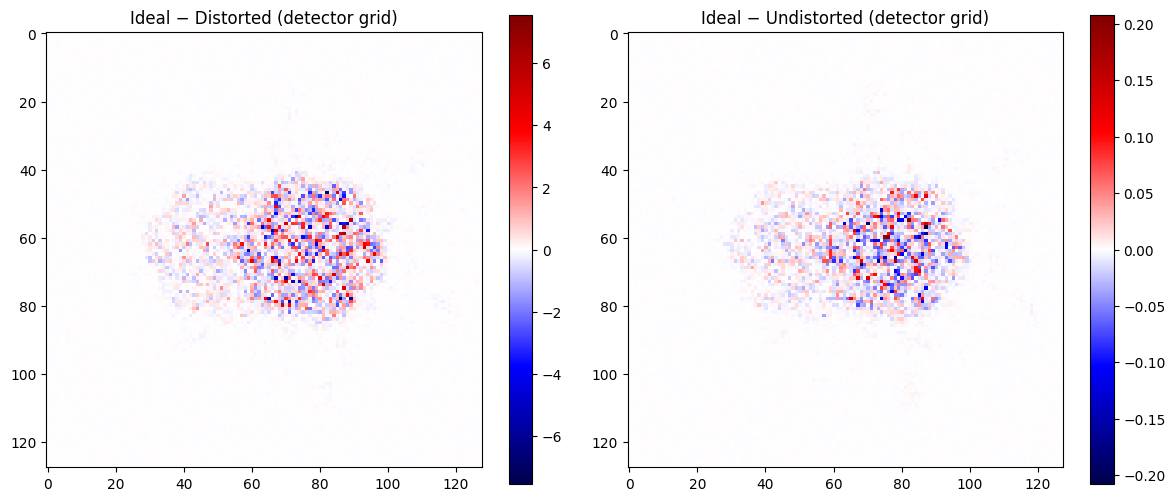

In [ ]:
# ==============================================================
# Per-pixel gradient solve – units reconciled (with downsampling & residual plots)
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import CenteredNorm
from scipy.ndimage import map_coordinates
import dLuxToliman
import dLux.utils as dlu
from global_polynomial_functions import (
    get_dither_offsets_uniform,
    get_dither_offsets_random
)

# ───────────── helper functions ───────────────────────────────
def central_grad(img, arcsec_per_sup_px):
    """Finite diff; output slope per arc-second."""
    gx = np.zeros_like(img); gy = np.zeros_like(img)
    gx[:,1:-1] = (img[:,2:] - img[:,:-2]) / (2*arcsec_per_sup_px)
    gy[1:-1,:] = (img[2: ,:] - img[:-2,:]) / (2*arcsec_per_sup_px)
    return gx, gy

def warp(img, field_sup, order=2):
    """Warp by field (Δx,Δy) in *super-pixels*."""
    dy, dx = field_sup[...,1], field_sup[...,0]
    y,x = np.indices(img.shape)
    return map_coordinates(img, [y-dy, x-dx], order=order, mode='reflect')

def rand_field(npix, p, amp_det_px, rng, ovsp):
    """Sparse ±amp detector-px → super-px field."""
    m   = rng.random((npix,npix)) < p
    sx  = rng.uniform(-amp_det_px, amp_det_px, (npix,npix))*m
    sy  = rng.uniform(-amp_det_px, amp_det_px, (npix,npix))*m
    return np.stack([sx,sy],-1)            # detector-px units

# ───────────── 1. optics & scale factors ──────────────────────
opt        = dLuxToliman.TolimanOpticalSystem(
                wf_npixels=256,
                psf_npixels=128,
                oversample=4)
ovsp       = opt.oversample 
print(f"oversample = {ovsp}")
arcsec_det = opt.psf_pixel_scale             # ″ per detector-px
arcsec_sup = arcsec_det / ovsp 
H = W = opt.psf_npixels * ovsp               # 512

# ───────────── 2. five-point dither pattern ──────────────────
dith_det_px   = [(0,0),(+0.2,0),(-0.2,0),(0,+0.2),(0,-0.2),
                 (+0.1,0),(-0.1,0),(0,+0.1),(0,-0.1)]
dith_arc_new  = [(dx*arcsec_det, dy*arcsec_det) for dx,dy in dith_det_px]
n_dith        = len(dith_det_px)              # 9

# ───────────── 3. ideal PSFs + gradients ─────────────────────
ideal, gx, gy = [], [], []
for x_arc, y_arc in dith_arc_new:
    src = dLuxToliman.sources.AlphaCen(
              n_wavels=5, separation=10.,
              position_angle=90,
              x_position=x_arc, y_position=y_arc)
    tel = dLuxToliman.telescopes.Toliman(opt, src)
    im  = np.asarray(tel.model())            # (512,512)
    ideal.append(im)
    gxi, gyi = central_grad(im, arcsec_sup)
    gx.append(gxi); gy.append(gyi)

ideal = np.stack(ideal)   # shape (9,512,512)
gx    = np.stack(gx)
gy    = np.stack(gy)

# ───────────── 4. sparse pixel distortion (25 %, ±0.01 det-px) ─
rng        = np.random.default_rng(0)
field_sup  = rand_field(H, p=0.25,
                       amp_det_px=0.01 * ovsp,
                       rng=rng, ovsp=ovsp)

# ───────────── 5. distorted cube ─────────────────────────────
dist = np.stack([warp(im, field_sup) for im in ideal])

# ───────────── 6. per-pixel LS solve (ridge λ) ───────────────
lam     = 1e-4
Δx_arc  = np.zeros((H,W))
Δy_arc  = np.zeros((H,W))

for j in range(H):
    Gx   = gx[:,j,:]
    Gy   = gy[:,j,:]
    R    = ideal[:,j,:] - dist[:,j,:]
    A11  = np.sum(Gx*Gx,0) + lam
    A22  = np.sum(Gy*Gy,0) + lam
    A12  = np.sum(Gx*Gy,0)
    det  = A11*A22 - A12*A12 + 1e-12
    b1   = np.sum(Gx*R,0)
    b2   = np.sum(Gy*R,0)
    Δx_arc[j] = (A22*b1 - A12*b2) / det
    Δy_arc[j] = (A11*b2 - A12*b1) / det

# ───────────── 7. convert arc-sec → super-pixel ─────────────
est_sup = np.dstack([Δx_arc/arcsec_sup,
                     Δy_arc/arcsec_sup])   # shape (512,512,2)

# ───────────── 8. down-sample back to 128×128 detector grid ───
est_det = est_sup.reshape(
    opt.psf_npixels, ovsp,
    opt.psf_npixels, ovsp,
    2
).mean(axis=(1,3))  # now (128,128,2)

# ───────────── 9. correct on-axis frame ──────────────────────
undist = warp(dist[0], -est_sup)

# ───────────── 10. down-sample PSFs & residuals ─────────────
def downsample(img, factor):
    h, w = img.shape
    return img.reshape(h//factor, factor, w//factor, factor).mean(axis=(1,3))

ideal_det   = downsample(ideal[0], ovsp)
dist_det    = downsample(dist[0],  ovsp)
undist_det  = downsample(undist,   ovsp)

# ───────────── 11. diagnostics & plots ───────────────────────
chi_dist = np.sum((ideal[0]  - dist[0])**2)
chi_corr = np.sum((ideal[0]  - undist)**2)
print(f"χ² distorted : {chi_dist:,.0f}")
print(f"χ² corrected : {chi_corr:,.0f}")

import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm

# compute detector-grid residuals
res1 = ideal_det - dist_det
res2 = ideal_det - undist_det

# determine symmetric color range around zero
vmax = max(abs(res1).max(), abs(res2).max())
norm = CenteredNorm(vcenter=0.0, halfrange=vmax)

# plot side by side with a single shared colorbar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

im = ax1.imshow(res1,
                origin='lower',
                cmap='seismic',
                norm=norm,
                interpolation='nearest')
ax1.set_title("Ideal − Distorted (detector grid)")
ax1.set_xlabel("X detector pixel")
ax1.set_ylabel("Y detector pixel")

ax2.imshow(res2,
           origin='lower',
           cmap='seismic',
           norm=norm,
           interpolation='nearest')
ax2.set_title("Ideal − Undistorted (detector grid)")
ax2.set_xlabel("X detector pixel")

# single colorbar for both axes
cbar = fig.colorbar(im, ax=[ax1, ax2], shrink=0.8, label="Intensity residual")
plt.show()



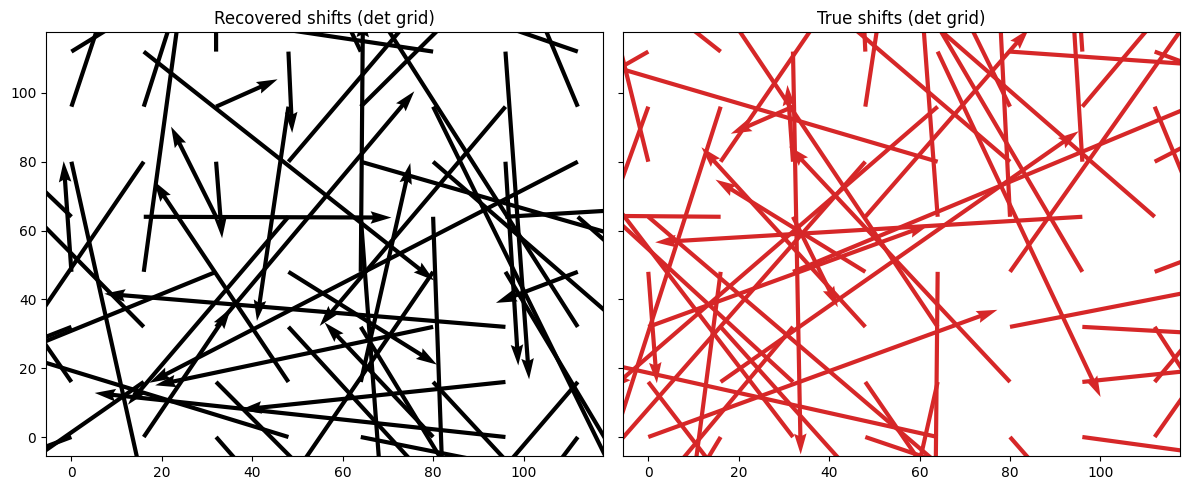

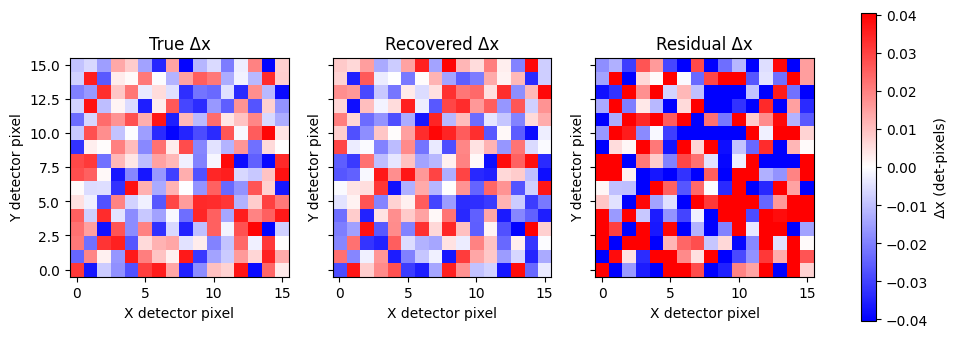

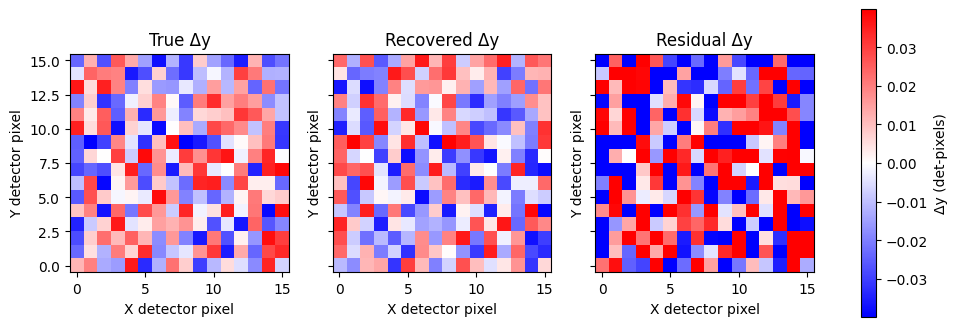

In [257]:
# assume est_det (128×128×2), field_sup (512×512×2) and ovsp are defined
# downsample the “true” field to detector grid
field_det = field_sup.reshape(
    est_det.shape[0], ovsp,
    est_det.shape[1], ovsp,
    2
).mean(axis=(1,3))   # now (128,128,2)

# unpack
U_rec = est_det[..., 0]
V_rec = est_det[..., 1]
U_true = field_det[..., 0]
V_true = field_det[..., 1]

# build a full mesh, then sub-sample by `step`
nrows, ncols = est_det.shape[:2]
x_full = np.arange(ncols)
y_full = np.arange(nrows)
X_full, Y_full = np.meshgrid(x_full, y_full)

step = 16  # change this to plot fewer/more arrows

X = X_full[::step, ::step]
Y = Y_full[::step, ::step]
Ur = U_rec[::step, ::step]
Vr = V_rec[::step, ::step]
Ut = U_true[::step, ::step]
Vt = V_true[::step, ::step]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

ax1.quiver(X, Y, Ur, Vr, scale=0.05)
ax1.set_title("Recovered shifts (det grid)")
ax1.invert_yaxis()

ax2.quiver(X, Y, Ut, Vt, scale=0.05, color="C3")
ax2.set_title("True shifts (det grid)")
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# choose a down‐sampling step for clarity
step = 8

# extract the Δx component on the detector grid
true_dx = field_det[::step, ::step, 0]
est_dx  = est_det [::step, ::step, 0]


# compute a common, symmetric color scale around zero
vmax = max(abs(true_dx).max(), abs(est_dx).max())
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=+vmax)

# plot True, Recovered, and Residual side by side
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)

im0 = ax0.imshow(true_dx,
                 origin='lower',
                 cmap='bwr',
                 norm=norm,
                 interpolation='nearest')
ax0.set_title('True Δx')
ax0.set_xlabel('X detector pixel')
ax0.set_ylabel('Y detector pixel')

im1 = ax1.imshow(est_dx,
                 origin='lower',
                 cmap='bwr',
                 norm=norm,
                 interpolation='nearest')
ax1.set_title('Recovered Δx')
ax1.set_xlabel('X detector pixel')
ax1.set_ylabel('Y detector pixel')

im2 = ax2.imshow(true_dx - est_dx,
                 origin='lower',
                 cmap='bwr',
                 norm=norm,
                 interpolation='nearest')
ax2.set_title('Residual Δx')
ax2.set_xlabel('X detector pixel')
ax2.set_ylabel('Y detector pixel')

# single colorbar spanning all three subplots
cbar = fig.colorbar(im1, ax=[ax0, ax1, ax2], shrink=0.8, label='Δx (det-pixels)')
plt.show()

true_dx = field_det[::step, ::step, 1]
est_dx  = est_det [::step, ::step, 1]
vmax = max(abs(true_dx).max(), abs(est_dx).max())
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=+vmax)
# plot True, Recovered, and Residual side by side
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)

im0 = ax0.imshow(true_dx,
                 origin='lower',
                 cmap='bwr',
                 norm=norm,
                 interpolation='nearest')
ax0.set_title('True Δy')
ax0.set_xlabel('X detector pixel')
ax0.set_ylabel('Y detector pixel')

im1 = ax1.imshow(est_dx,
                 origin='lower',
                 cmap='bwr',
                 norm=norm,
                 interpolation='nearest')
ax1.set_title('Recovered Δy')
ax1.set_xlabel('X detector pixel')
ax1.set_ylabel('Y detector pixel')

im2 = ax2.imshow(true_dx - est_dx,
                 origin='lower',
                 cmap='bwr',
                 norm=norm,
                 interpolation='nearest')
ax2.set_title('Residual Δy')
ax2.set_xlabel('X detector pixel')
ax2.set_ylabel('Y detector pixel')

# single colorbar spanning all three subplots
cbar = fig.colorbar(im1, ax=[ax0, ax1, ax2], shrink=0.8, label='Δy (det-pixels)')
plt.show()


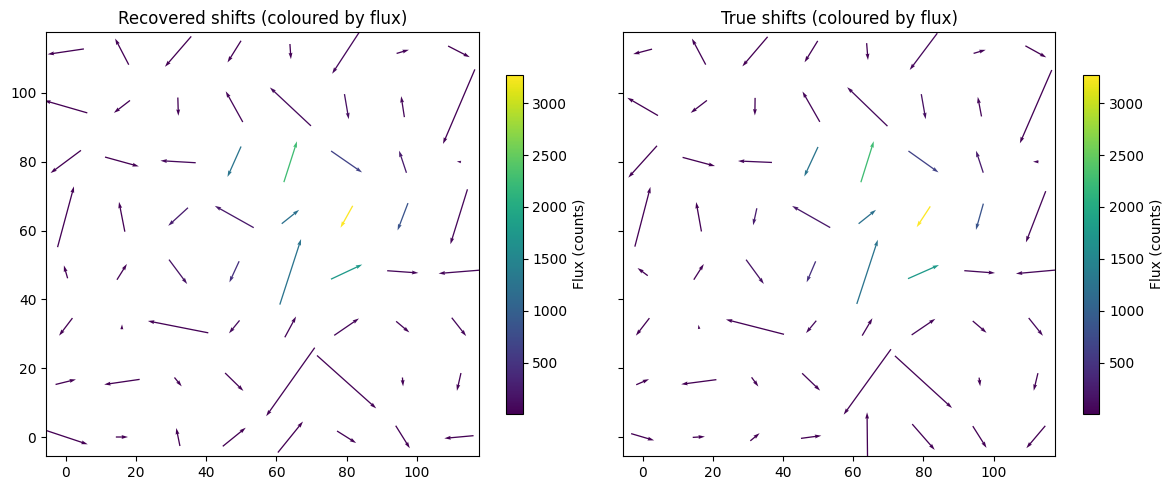

In [226]:
import numpy as np
import matplotlib.pyplot as plt

# assume est_det (128×128×2), field_sup (512×512×2), ideal_det (128×128), and ovsp are defined

# down-sample the “true” field to detector grid
field_det = field_sup.reshape(
    est_det.shape[0], ovsp,
    est_det.shape[1], ovsp,
    2
).mean(axis=(1,3))   # now (128,128,2)

# unpack shift components
U_rec = est_det[..., 0]
V_rec = est_det[..., 1]
U_true = field_det[..., 0]
V_true = field_det[..., 1]

# build a full mesh, then sub-sample by `step`
nrows, ncols = est_det.shape[:2]
x_full = np.arange(ncols)
y_full = np.arange(nrows)
X_full, Y_full = np.meshgrid(x_full, y_full)

step = 16  # plot every 16th arrow

X = X_full[::step, ::step]
Y = Y_full[::step, ::step]
Ur = U_rec[::step, ::step]
Vr = V_rec[::step, ::step]
Ut = U_true[::step, ::step]
Vt = V_true[::step, ::step]

# get the flux at each detector pixel, subsampled
flux_sub = ideal_det[::step, ::step]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# recovered shifts, coloured by flux_sub
q1 = ax1.quiver(
    X, Y, Ur, Vr, flux_sub,    # flux_sub as the 5th positional argument
    cmap="viridis",
    scale=0.05,
    width=0.003,
    pivot="middle"
)
ax1.set_title("Recovered shifts (coloured by flux)")
ax1.invert_yaxis()
cbar1 = fig.colorbar(q1, ax=ax1, shrink=0.8, label="Flux (counts)")

# true shifts, coloured by flux_sub for comparison
q2 = ax2.quiver(
    X, Y, Ut, Vt, flux_sub,
    cmap="viridis",
    scale=0.05,
    width=0.003,
    pivot="middle"
)
ax2.set_title("True shifts (coloured by flux)")
ax2.invert_yaxis()
cbar2 = fig.colorbar(q2, ax=ax2, shrink=0.8, label="Flux (counts)")

plt.tight_layout()
plt.show()


In [ ]:
opt        = dLuxToliman.TolimanOpticalSystem(wf_npixels=256,
                                              psf_npixels=128,
                                              oversample=4)
ovsp       = opt.oversample                  # 4
arcsec_det = opt.psf_pixel_scale             # ″ per detector-px  (≈ 0.375″)
arcsec_sup = arcsec_det / ovsp 
det_pixel_size = arcsec_sup             # ″ per super-px     (≈ 0.0938″)
H = W = opt.psf_npixels * ovsp

dith_det_px = [(0,0),(+0.2,0),(-0.2,0),(0,+0.2),(0,-0.2), (+0.1, 0), (-0.1, 0), (0, +0.1), (0, -0.1)]
dith_arc_new   = [(dx*arcsec_det, dy*arcsec_det) for dx,dy in dith_det_px]
n_dith      = len(dith_det_px)

# ───────────── 3. ideal PSFs + gradients ─────────────────────
ideal, gx, gy = [], [], []

src = dLuxToliman.sources.AlphaCen(n_wavels=5, separation=10.,
                                   position_angle=90,
                                   x_position=0, y_position=0)
tel = dLuxToliman.telescopes.Toliman(opt, src)
#im  = np.asarray(tel.model())           # (512,512)
im = tel.model()
im

# for x_arc, y_arc in dith_arc_new:
#     src = dLuxToliman.sources.AlphaCen(n_wavels=5, separation=10.,
#                                        position_angle=90,
#                                        x_position=x_arc, y_position=y_arc)
#     print(src)
#     tel = dLuxToliman.telescopes.Toliman(opt, src)
#     im  = np.asarray(tel.model())           # (512,512)
#     ideal.append(im)
#     gxi, gyi = central_grad(im, arcsec_sup)
#     gx.append(gxi); gy.append(gyi)



Array([[6.9735484, 7.359202 , 7.4867144, ..., 3.7298572, 3.3275537,
        3.268213 ],
       [6.484029 , 6.757941 , 6.792128 , ..., 3.794373 , 3.5727773,
        3.6920538],
       [5.9643   , 6.145018 , 6.111121 , ..., 3.992748 , 3.9885411,
        4.298011 ],
       ...,
       [4.525343 , 4.261386 , 4.1435213, ..., 3.9419885, 4.158927 ,
        4.25867  ],
       [4.181011 , 4.108624 , 4.2107143, ..., 4.177084 , 4.371981 ,
        4.463572 ],
       [4.079071 , 4.200363 , 4.500862 , ..., 4.8397655, 4.9719944,
        5.007472 ]], dtype=float32)

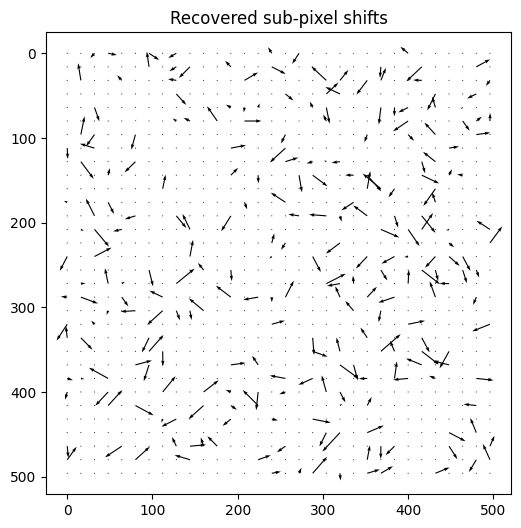

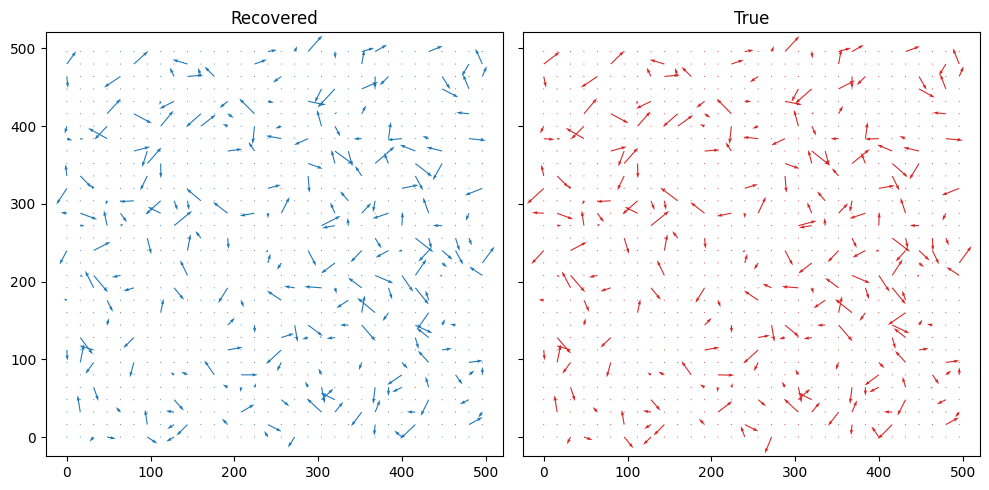

In [199]:
step = 16
# U and V are shape (nrows, ncols)
U = est_sup[::step, ::step, 0]
V = est_sup[::step, ::step, 1]
nrows, ncols = U.shape

# Build X,Y so they line up with the subsampled grid
x = np.arange(ncols)*step   # true x‐coordinates of each arrow
y = np.arange(nrows)*step   # true y‐coordinates of each arrow
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(6,6))
plt.quiver(X, Y, U, V, scale=1)
plt.title("Recovered sub-pixel shifts")
plt.gca().invert_yaxis()    # if you want origin = top-left
plt.show()


# And for comparison with the true field:
U_true = field_sup[::step, ::step, 0]
V_true = field_sup[::step, ::step, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
for ax, (Ua, Va, title) in zip(
    (ax1, ax2),
    ((U,    V,    "Recovered"),
     (U_true, V_true, "True"))
):
    ax.quiver(X, Y, Ua, Va, scale=1, color=('C0' if title=="Recovered" else 'C3'))
    ax.set_title(title)
    ax.invert_yaxis()

plt.tight_layout()


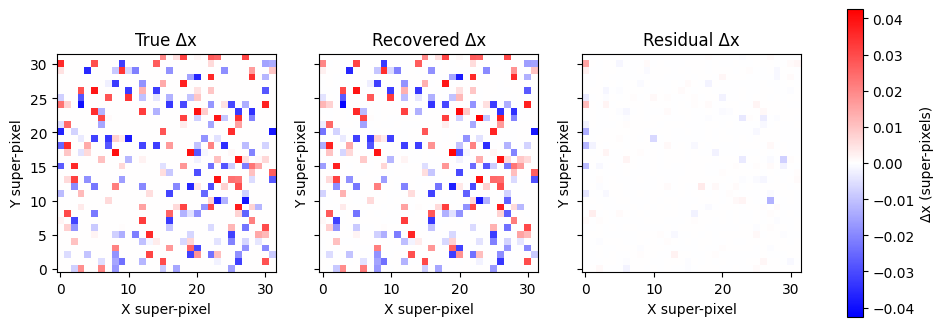

In [200]:
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm

step = 16              # show only every 8-th pixel in x and y
sub  = field_sup[::step, ::step, 0]        # Δx plane, down-sampled

H, W = field_sup.shape[:2]
# extent keeps the axes in full-frame pixel coordinates
#extent = [0, W, 0, H]          # left, right, bottom, top


import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Extract the Δx component  (super-pixel units)
true_dx = field_sup[::step, ::step, 0]
est_dx  = est_sup [::step, ::step, 0]

# Build a common, symmetric color scale around zero
vmax = max(abs(true_dx).max(), abs(est_dx).max())
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=+vmax)

# Plot
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)

im0 = ax0.imshow(true_dx,
                 origin='lower',
                 cmap='bwr',
                 norm=norm,
                 interpolation='nearest')
ax0.set_title('True Δx')
ax0.set_xlabel('X super-pixel')
ax0.set_ylabel('Y super-pixel')

im1 = ax1.imshow(est_dx,
                 origin='lower',
                 cmap='bwr',
                 norm=norm,
                 interpolation='nearest')
ax1.set_title('Recovered Δx')
ax1.set_xlabel('X super-pixel')
ax1.set_ylabel('Y super-pixel')


im2 = ax2.imshow(true_dx - est_dx,
                 origin='lower',
                 cmap='bwr',
                 norm=norm,
                 interpolation='nearest')
ax2.set_title('Residual Δx')
ax2.set_xlabel('X super-pixel')
ax2.set_ylabel('Y super-pixel')
# Single colorbar for both
cbar = fig.colorbar(im1, ax=[ax0, ax1, ax2], shrink=0.8, label='Δx (super-pixels)')

#plt.tight_layout()
plt.show()

